# Travel Insurance Claim Detection System
**Dibuat oleh : Dinmar Pratama**

# Problem Statement

Masalah Utama:

Banyaknya klaim asuransi dari pelanggan yang bepergian ke luar negeri menyebabkan kesulitan bagi agensi dalam membedakan klaim yang valid dan tidak valid. Hal ini memerlukan model yang dapat mengklasifikasikan klaim secara lebih akurat dan efisien untuk mencegah pembayaran klaim yang tidak memenuhi syarat.

Pertanyaan Analitis:

- Fitur apa yang paling berpengaruh terhadap status klaim (Claim)?
- Apakah lama perjalanan atau destinasi tertentu meningkatkan probabilitas klaim?
- Apakah faktor demografis, seperti usia atau jenis kelamin, memengaruhi keabsahan klaim?
- Bagaimana dampak jenis produk asuransi atau kanal distribusi terhadap klaim?
- Apakah terdapat pola klaim berdasarkan nilai penjualan polis atau jumlah komisi yang diperoleh agensi?

# Tentang Dataset
Data Source : [Data Travel Insurance](https://drive.google.com/drive/folders/1iVx5k6tWglqfHb05o0DElg8JHg7VVG_J)

**Penjelasan tentang dataset**

Asuransi perjalanan merupakan salah satu jenis asuransi yang memberikan perlindungan selama kita melakukan perjalanan baik di dalam negeri maupun luar negeri. Beberapa negara bahkan telah mewajibkan para pelancong untuk memiliki asuransi perjalanan, misalnya negara-negara di Eropa dan Amerika. Besarnya premi tergantung pada cakupan yang diinginkan, lamanya perjalanan, dan tujuan perjalanan. Perusahaan yang bergerak di bidang asuransi perjalanan ingin mengetahui pemegang polis yang akan mengajukan klaim asuransi untuk mendapatkan cakupan. Data pemegang polis pada perusahaan asuransi merupakan data historis yang terdiri dari destinasi, produk asuransi, dan sebagainya.

**Fitur** Targetnya Kolom `Claim`

- `Agency`: Nama agen atau perusahaan yang menjual asuransi perjalanan
- `Agency Type`: Jenis agensi asuransi perjalanan
- `Distribution Channel`: Saluran agensi asuransi perjalanan
- `Product Name`: Nama produk asuransi perjalanan
- `Gender`: Jenis kelamin tertanggung
- `Duration`: Durasi perjalanan
- `Destination`: Tujuan perjalanan
- `Net Sales`: Jumlah penjualan polis asuransi perjalanan
- `Commision (in value)`: Komisi yang diterima untuk agensi asuransi perjalanan
- `Age`: Usia tertanggung
- `Claim`: Status klaim


# Import Library yang digunakan

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy.stats import kstest, normaltest
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.experimental import enable_iterative_imputer  # Enable experimental feature
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

from jcopml.tuning import grid_search_params as gsp
from jcopml.tuning import random_search_params as rsp
from category_encoders import BinaryEncoder

import pickle
import warnings
warnings.filterwarnings('ignore')

# Data Understanding

## Load Data

In [105]:
df = pd.read_csv("data_travel_insurance.csv")
df

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,No
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No


## Data Information

In [106]:
# analisis data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


In [107]:
df.describe()

,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


In [108]:
df["Claim"].value_counts(normalize=True)

Claim
No     0.984727
Yes    0.015273
Name: proportion, dtype: float64

In [109]:
# ubah kolom Claim menjadi nilai 0 dan 1
df['Claim'] = np.where(df['Claim'] == 'Yes', 1, 0)
df


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,0
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,0
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,0
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,1
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,0
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,0
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,0


In [110]:
# ubah nama kolom Commision (in value) menjadi Commission
df.rename(columns={'Commision (in value)': 'Commission'}, inplace=True)
df

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commission,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.00,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.00,33,0
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.70,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.00,59,0
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.00,28,0
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,1
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,0
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,0
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,0


## Missing Values

In [111]:
pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'missing_value': df.isna().sum().values,
    'missing_value(%)': df.isna().mean().values * 100
}).round(2)

,feature,data_type,missing_value,missing_value(%)
0,Agency,object,0,0.00
1,Agency Type,object,0,0.00
2,Distribution Channel,object,0,0.00
3,Product Name,object,0,0.00
4,Gender,object,31647,71.39
5,Duration,int64,0,0.00
6,Destination,object,0,0.00
7,Net Sales,float64,0,0.00
8,Commission,float64,0,0.00
9,Age,int64,0,0.00


Tabel di atas menunjukkan bahwa dataset ini memiliki missing value hanya pada kolom Gender. Missing value ini akan ditangani dengan mendrop atau membuang kolom Gender agar dataset menjadi lebih baik."

**Matrix**

<Axes: >

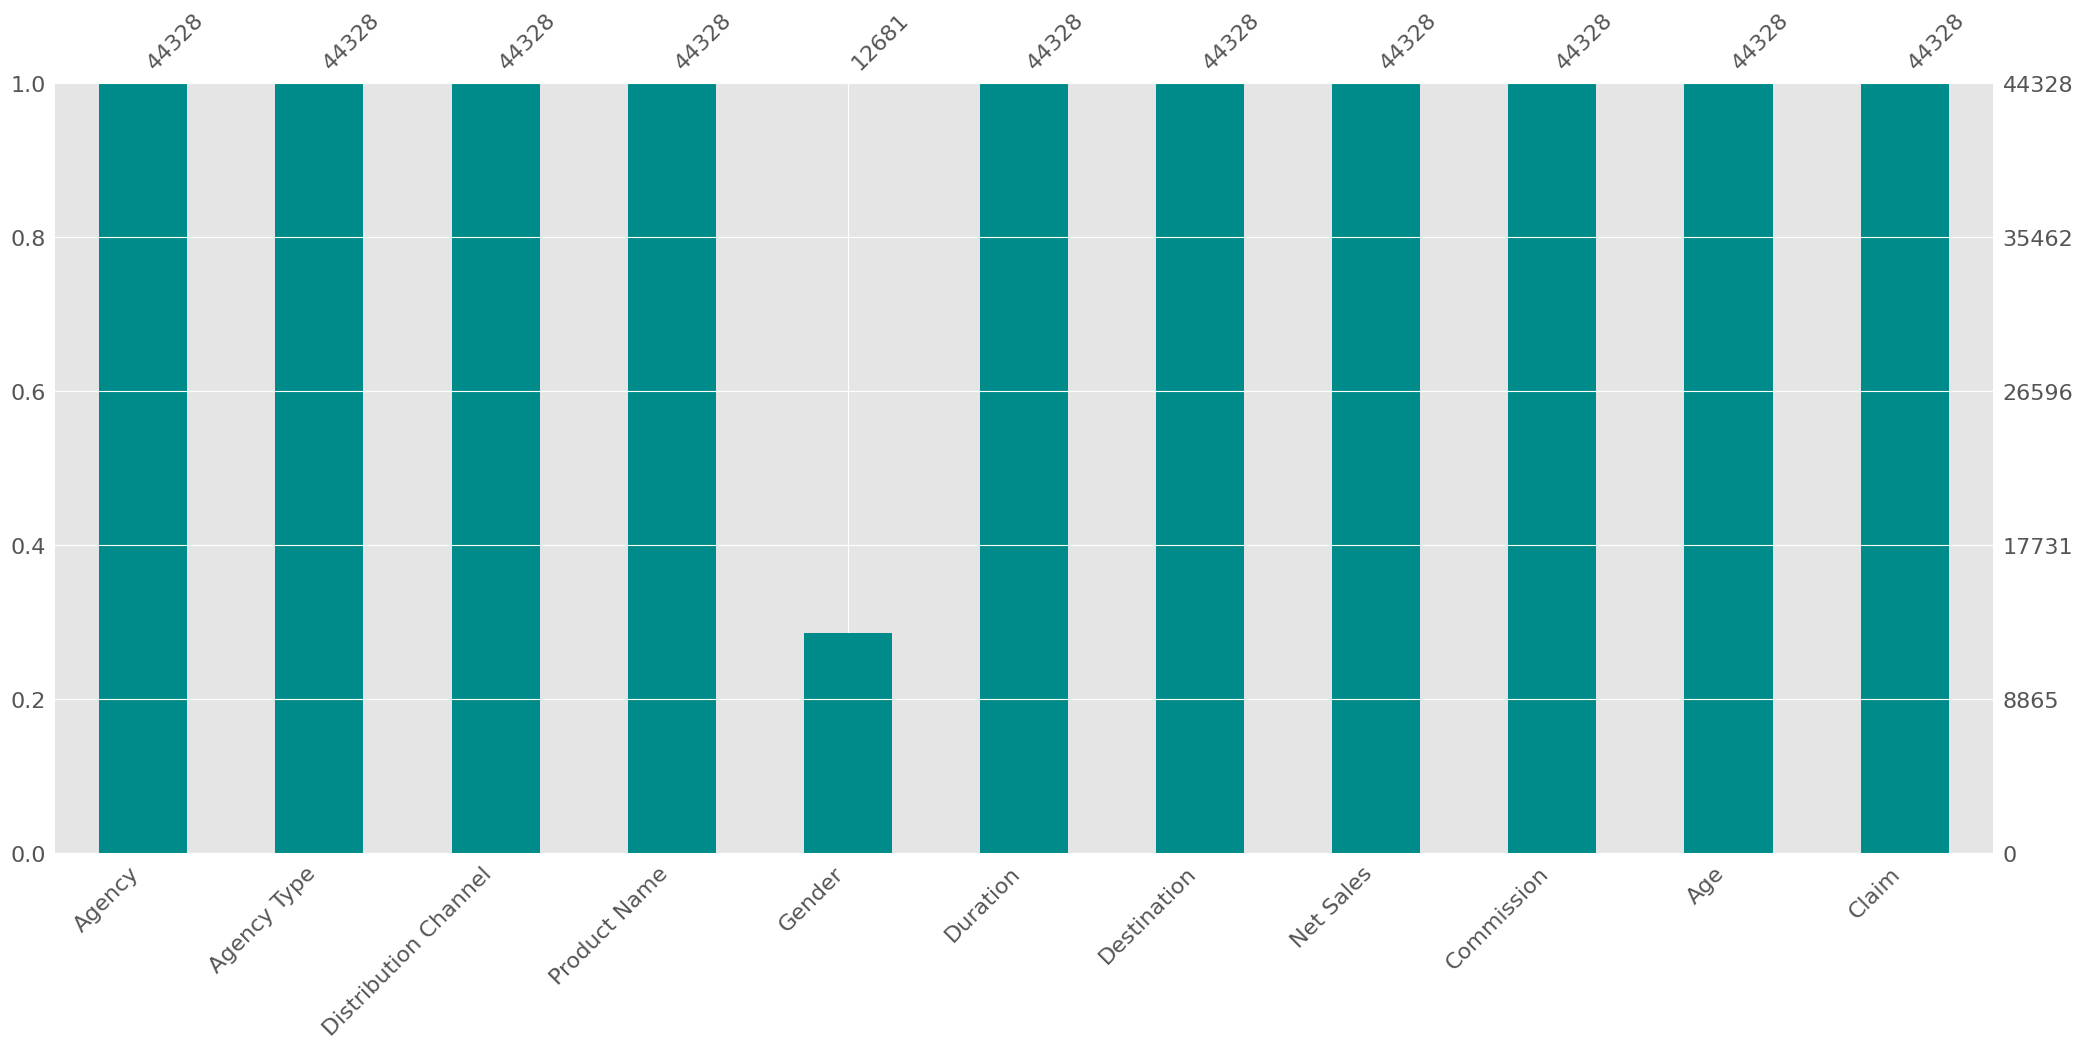

In [112]:
msno.bar(df, color=("darkcyan"))

<Axes: >

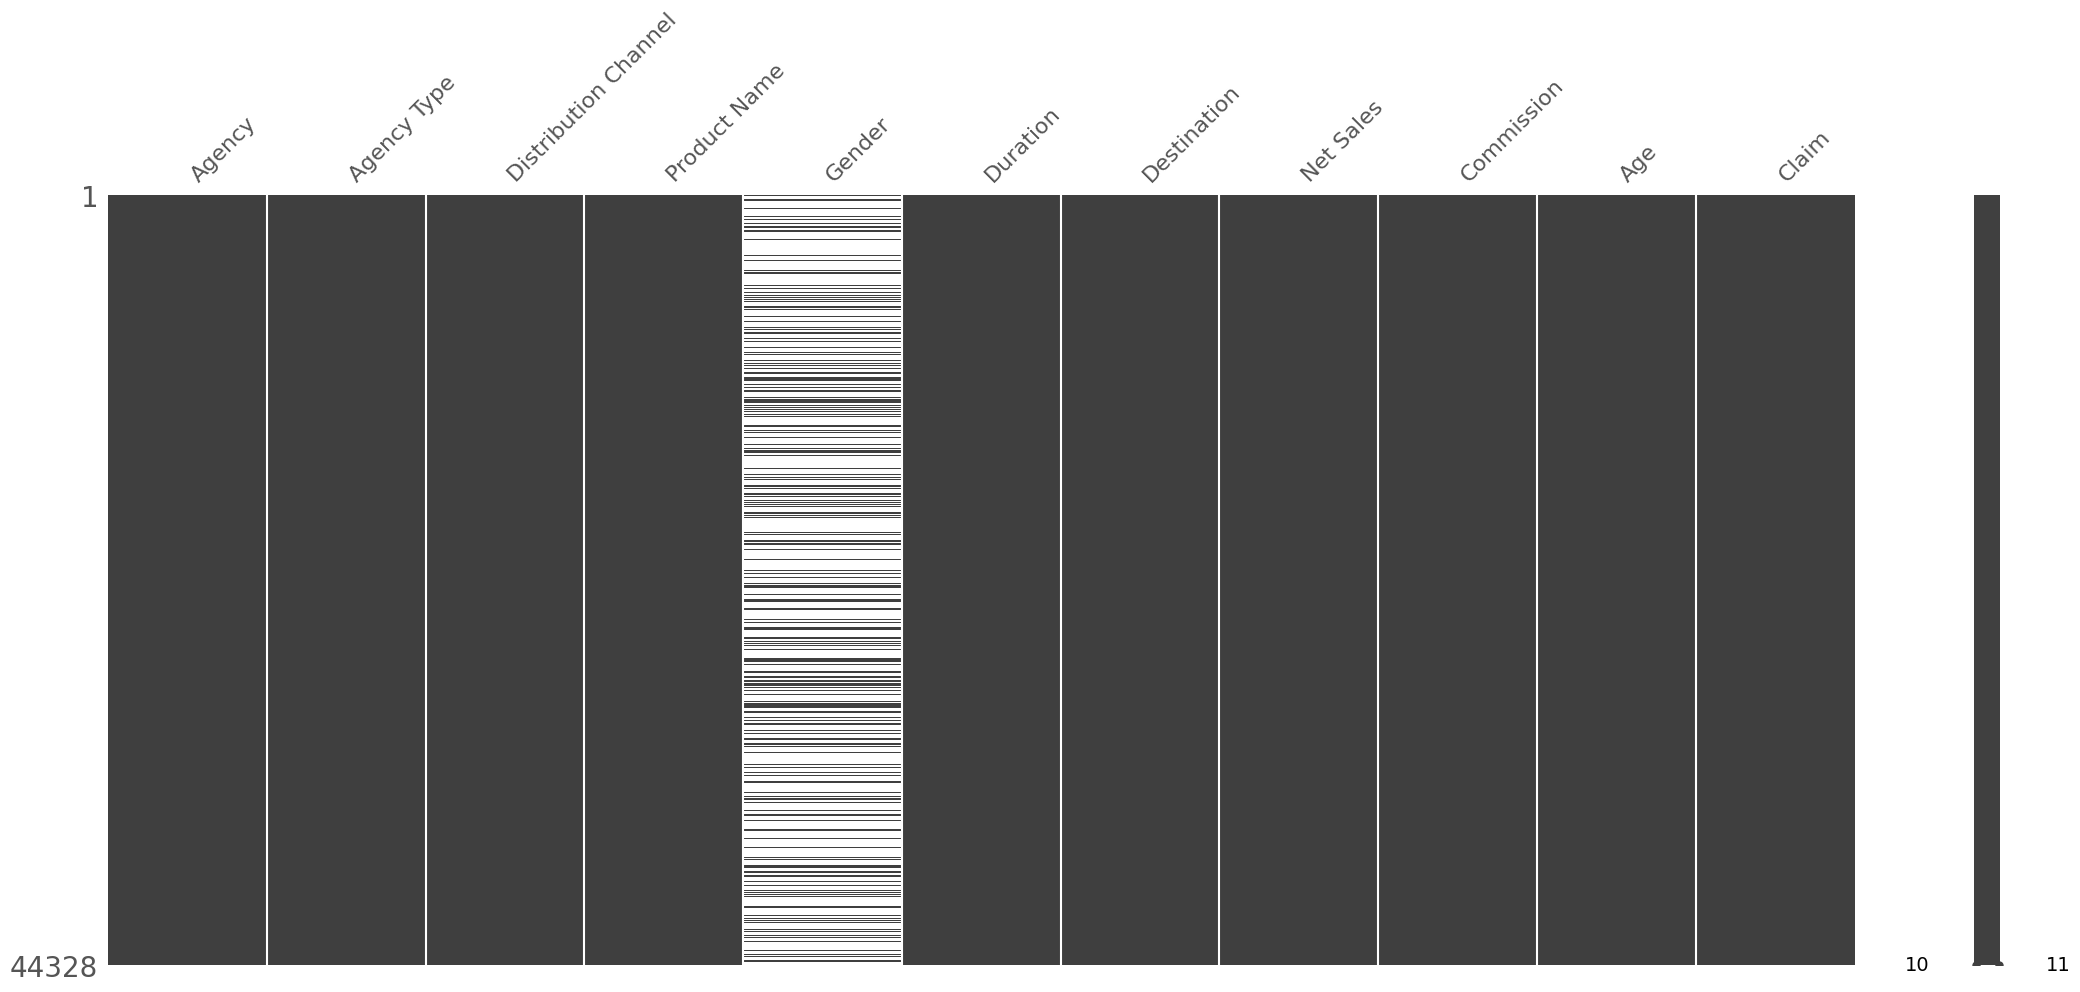

In [113]:
msno.matrix(df)

Dengan menggunakan visualisasi data dalam bentuk Barplot dan Matrix dapat dilihat cuma kolom Gender saja yang mempunyai missing value dan kolom tersebut hanya terisi sebanyak 28,61% saja

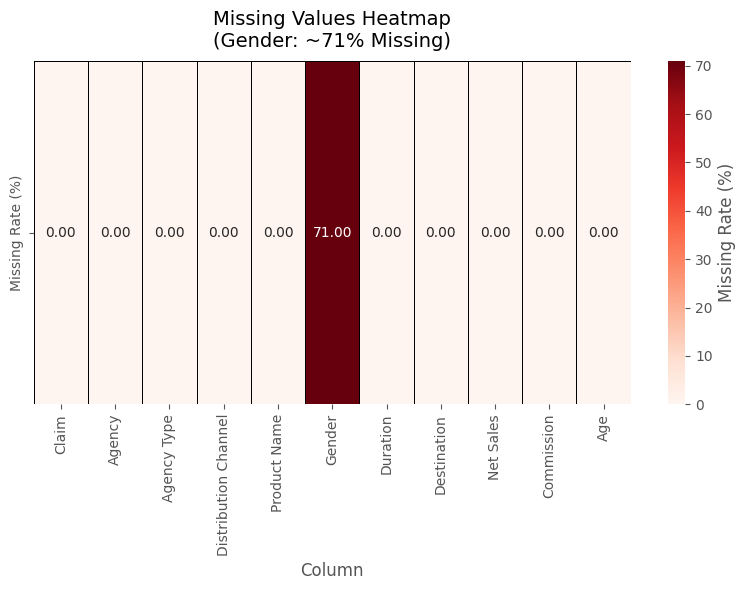

Heatmap disimpan sebagai 'missing_values_heatmap.png'


In [114]:
# Simulasi data untuk missing values (ganti dengan df asli jika tersedia)
columns = ['Claim', 'Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 
           'Gender', 'Duration', 'Destination', 'Net Sales', 'Commission', 'Age']
missing_rates = [0, 0, 0, 0, 0, 0.71, 0, 0, 0, 0, 0]  # 71% missing di Gender, lainnya 0%
missing_df = pd.DataFrame({
    'Column': columns,
    'Missing Rate (%)': [rate * 100 for rate in missing_rates]
})

# Atur figure
plt.figure(figsize=(8, 6))

# Buat heatmap
sns.heatmap(
    missing_df.set_index('Column')[['Missing Rate (%)']].T, 
    annot=True, fmt='.2f', cmap='Reds', cbar_kws={'label': 'Missing Rate (%)'},
    linewidths=0.5, linecolor='black'
)

# Highlight Gender
for text in plt.gca().texts:
    if text.get_text() == '71.0':
        text.set_weight('bold')
        text.set_color('black')
        text.set_fontsize(12)

# Tambahkan judul
plt.title('Missing Values Heatmap\n(Gender: ~71% Missing)', fontsize=14, pad=10)
plt.xlabel('Column', fontsize=12)
plt.ylabel('')

# Atur layout
plt.tight_layout()

# Simpan sebagai PNG
plt.savefig('missing_values_heatmap.png', bbox_inches='tight', dpi=300)
plt.show()
print("Heatmap disimpan sebagai 'missing_values_heatmap.png'")

In [115]:
pd.DataFrame({
    'age_range':['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100 or above'],
    'missing_values':[
        df[(df['Age']>=0) & (df['Age']<10)]['Gender'].isna().sum(),
        df[(df['Age']>=10) & (df['Age']<20)]['Gender'].isna().sum(),
        df[(df['Age']>=20) & (df['Age']<30)]['Gender'].isna().sum(),
        df[(df['Age']>=30) & (df['Age']<40)]['Gender'].isna().sum(),
        df[(df['Age']>=40) & (df['Age']<50)]['Gender'].isna().sum(),
        df[(df['Age']>=50) & (df['Age']<60)]['Gender'].isna().sum(),
        df[(df['Age']>=60) & (df['Age']<70)]['Gender'].isna().sum(),
        df[(df['Age']>=70) & (df['Age']<80)]['Gender'].isna().sum(),
        df[(df['Age']>=80) & (df['Age']<90)]['Gender'].isna().sum(),
        df[(df['Age']>=90) & (df['Age']<100)]['Gender'].isna().sum(),
        df[df['Age']>=100]['Gender'].isna().sum()
    ]
})

,age_range,missing_values
0,0-9,0
1,10-19,26
2,20-29,2768
3,30-39,22059
4,40-49,3763
5,50-59,2036
6,60-69,758
7,70-79,126
8,80-89,10
9,90-99,0


In [116]:
# menghapus kolom Gender
df = df.drop(['Gender'], axis=1)
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commission,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,33,0
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,59,0
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,0
...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,36,1
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,0
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,50,0
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,36,0


Dengan jumlah missing values sebanyak 31647 pada Kolom Gender, akhirnya untuk mengantisipasi adalah dengan didrop atau dibuang kolom Gendernya.

## Duplicate Values

In [117]:
# mendeteksi duplikasi data
print("Jumlah data duplikat:", df.duplicated().sum())

Jumlah data duplikat: 5004


In [118]:
df[df.duplicated()]

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commission,Age,Claim
331,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.00,36,0
360,EPX,Travel Agency,Online,Cancellation Plan,6,MALAYSIA,10.0,0.00,36,0
473,EPX,Travel Agency,Online,Cancellation Plan,11,MALAYSIA,10.0,0.00,36,0
488,EPX,Travel Agency,Online,Cancellation Plan,2,SINGAPORE,10.0,0.00,36,0
636,EPX,Travel Agency,Online,1 way Comprehensive Plan,3,MALAYSIA,20.0,0.00,36,0
...,...,...,...,...,...,...,...,...,...,...
44309,EPX,Travel Agency,Online,2 way Comprehensive Plan,49,VIET NAM,20.0,0.00,36,0
44311,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,5,THAILAND,29.7,17.82,38,0
44313,EPX,Travel Agency,Online,Cancellation Plan,5,CHINA,14.0,0.00,36,0
44315,EPX,Travel Agency,Online,1 way Comprehensive Plan,5,THAILAND,20.0,0.00,36,0


In [119]:
# menghapus duplikasi data
df = df.drop_duplicates().reset_index(drop=True)
print(f'Jumlah baris dataset: {df.shape[0]}\nJumlah kolom dataset: {df.shape[1]}')

Jumlah baris dataset: 39324
Jumlah kolom dataset: 10


In [120]:
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commission,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,0
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,33,0
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,0
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,59,0
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,0
...,...,...,...,...,...,...,...,...,...,...
39319,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,36,1
39320,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,0
39321,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,50,0
39322,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,36,0


### Fitur Numerik

#### Statistik Deskriptif

In [121]:
df.describe()

,Duration,Net Sales,Commission,Age,Claim
count,39324.000000,39324.00000,39324.000000,39324.000000,39324.000000
mean,52.275989,42.20253,10.386189,39.833054,0.017114
std,113.404932,49.70403,20.345275,13.225494,0.129699
min,-1.000000,-357.50000,0.000000,0.000000,0.000000
25%,11.000000,19.00000,0.000000,35.000000,0.000000
50%,25.000000,29.00000,0.000000,36.000000,0.000000
75%,57.000000,50.00000,11.880000,44.000000,0.000000
max,4881.000000,810.00000,283.500000,118.000000,1.000000


#### Data Distribusi

<Figure size 2000x1500 with 0 Axes>

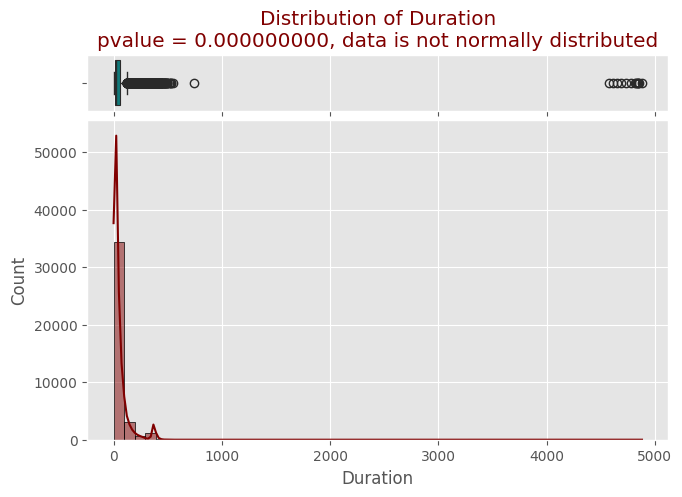

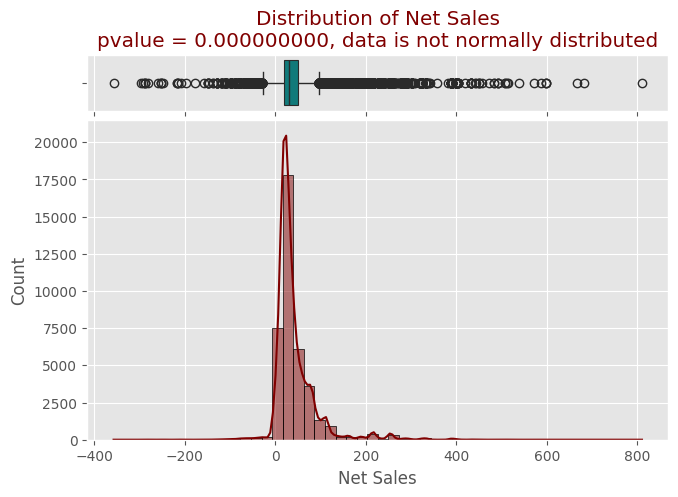

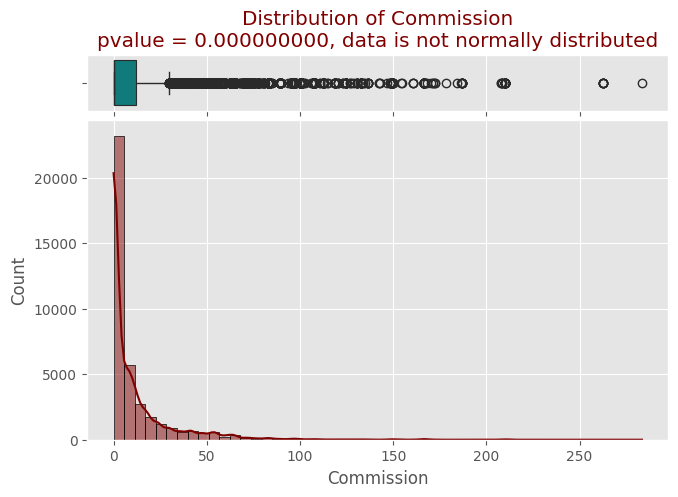

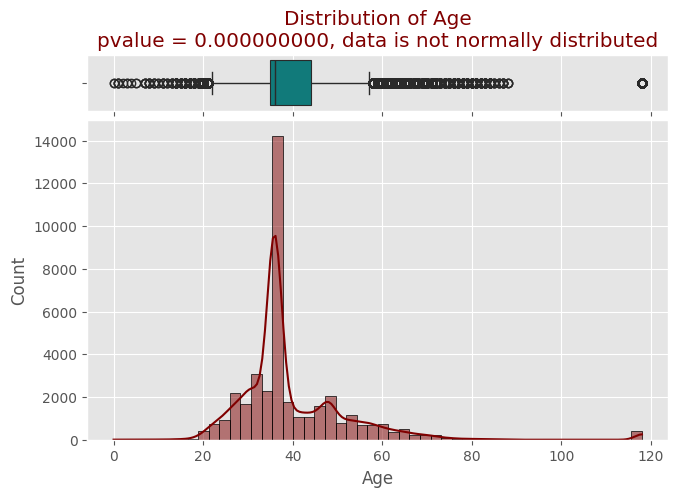

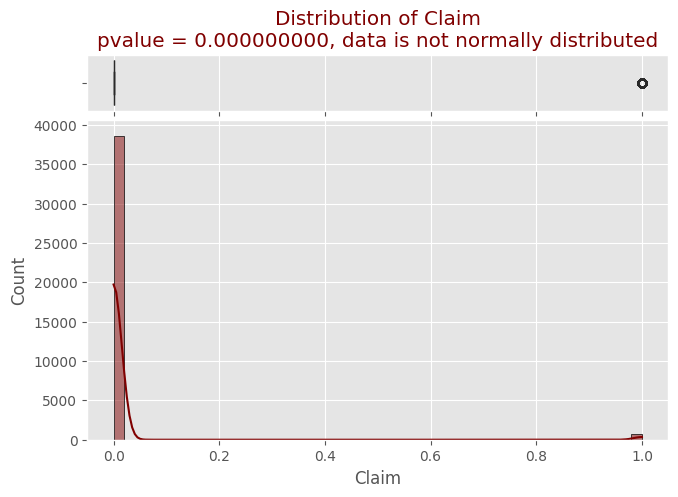

In [122]:
# Select numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns

# Plot the distribution of numerical data in the dataset along with hypothesis testing using normaltest
plt.figure(figsize=(20,15))

for column in numerical_columns:

    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(7.5,5), 
                                    gridspec_kw={"height_ratios": (.15, .85), "hspace": 0.05})

    # Perform normality test (normaltest)
    stat, pvalue = normaltest(df[column].dropna())

    # Determine normality based on p-value
    if pvalue > 0.05:
        distribution = f'pvalue = {pvalue:.9f}, data is normally distributed'
    else:
        distribution = f'pvalue = {pvalue:.9f}, data is not normally distributed'

    # Set title with result of normality test
    ax1.set_title(f"Distribution of {column}\n{distribution}", color="maroon")

    # Boxplot for the column with transparent background
    sns.boxplot(x=df[column], ax=ax1, color="darkcyan", 
                boxprops=dict(linewidth=0.8))  # Transparent boxplot
    ax1.set(xlabel="")

    # Histogram and KDE for the column
    sns.histplot(df[column], ax=ax2, stat="count", kde=True, bins=50, color="maroon", edgecolor="black")

# Show all plots after finishing the loop
plt.show()

#### Matrik Korelasi

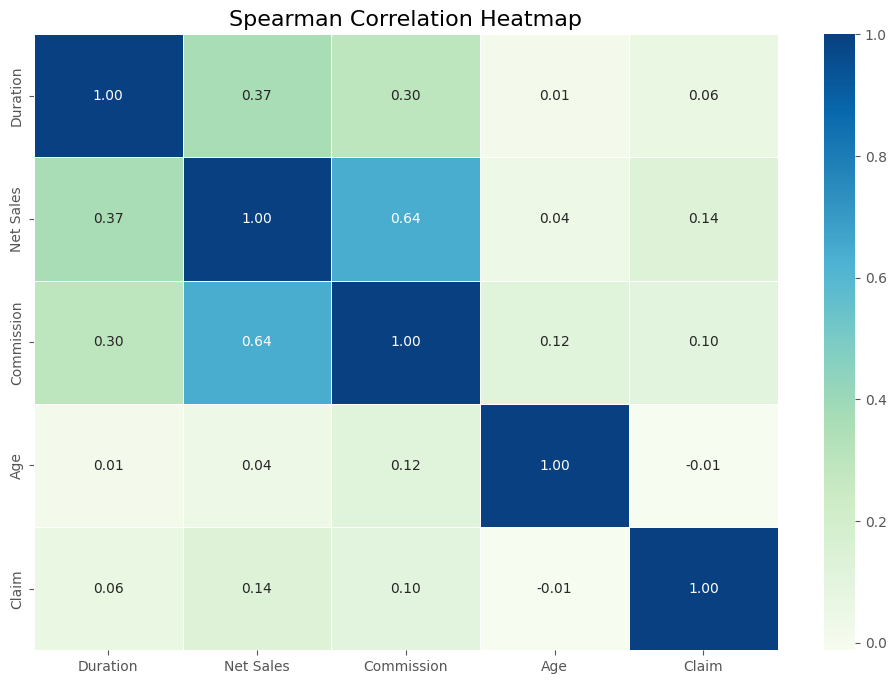

In [123]:
# membuat korelasi heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='GnBu', fmt=".2f", linewidths=0.5)
plt.title("Spearman Correlation Heatmap", fontsize=16)
plt.show()

### Fitur Kategorik

#### Statistik Deskriptif

In [124]:
df.describe(include = 'object')

,Agency,Agency Type,Distribution Channel,Product Name,Destination
count,39324,39324,39324,39324,39324
unique,16,2,2,26,138
top,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE
freq,20990,28096,38613,11009,8106


#### Nilai Unique

In [125]:
kategorik = df.select_dtypes(include = 'object')
kategorik.nunique()

Agency                   16
Agency Type               2
Distribution Channel      2
Product Name             26
Destination             138
dtype: int64

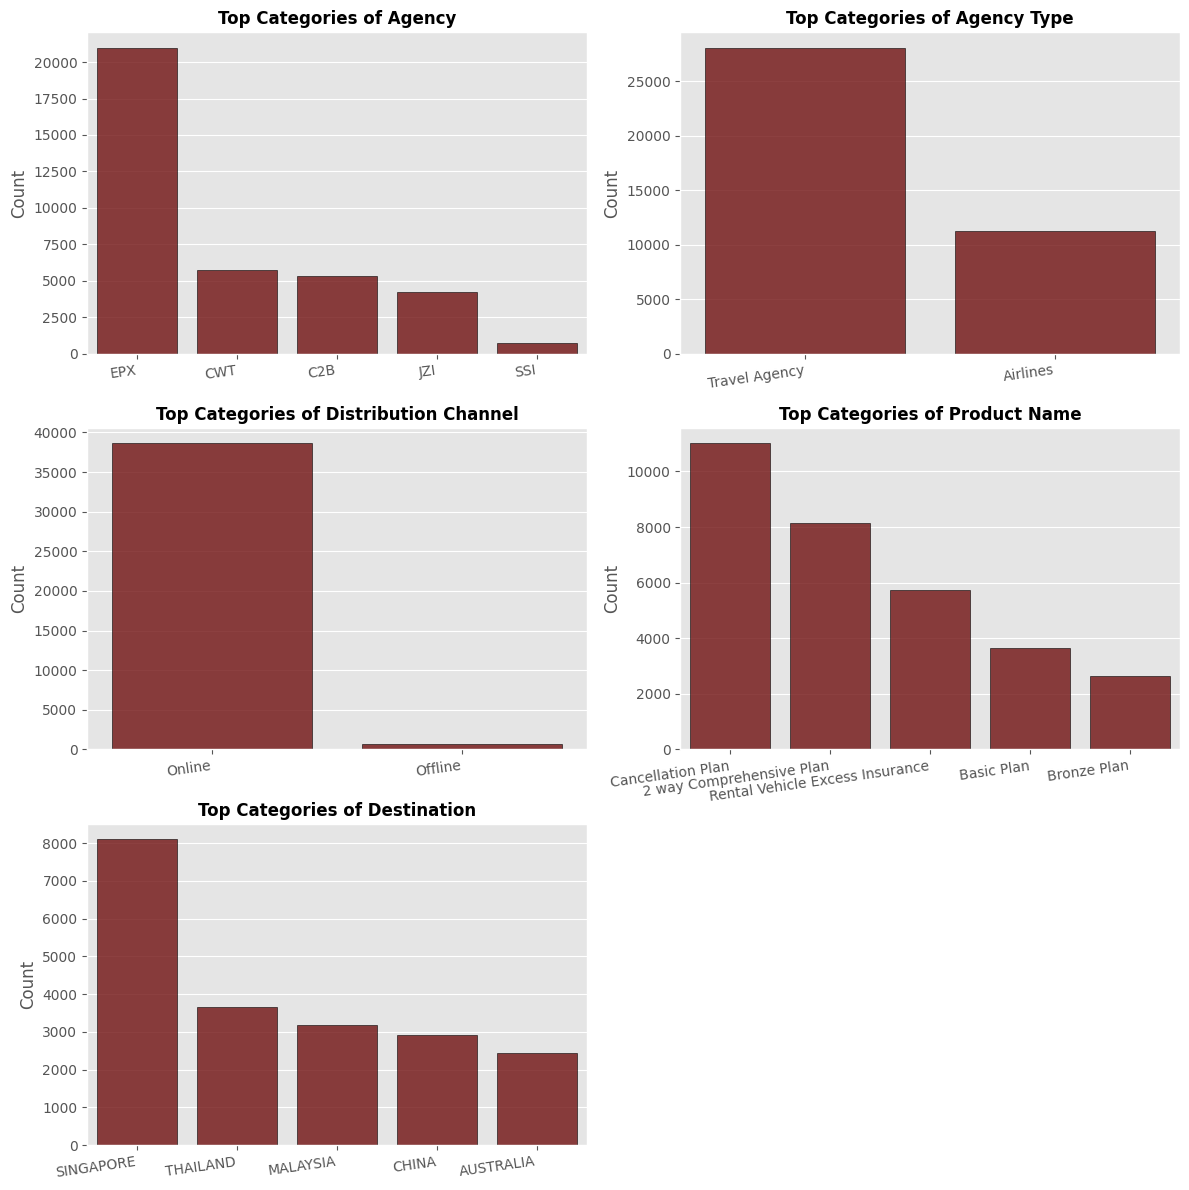

In [126]:
# Jumlah kategori
num_columns = len(kategorik.columns)
rows = (num_columns // 2) + (num_columns % 2)  # Menentukan jumlah baris (max 2 kolom per baris)

fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4))  # Buat subplot grid fleksibel
axes = axes.flatten()  # Flatten untuk indexing yang mudah

# Looping untuk setiap kolom kategorik
for i, setiap_kolom in enumerate(kategorik.columns):
    category_counts = df[setiap_kolom].value_counts().head(5)  # Ambil top 5 kategori
    
    sns.barplot(x=category_counts.index, y=category_counts.values, 
                color="maroon", alpha=0.8, ax=axes[i], edgecolor='black')  # Gunakan axes[i]
    
    axes[i].set_title(f"Top Categories of {setiap_kolom}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")
    # memiringkan text
    plt.setp(axes[i].get_xticklabels(), rotation=8, ha="right")

# Hapus subplot kosong jika ada
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [127]:
df_info = pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'missing_values': df.isna().sum().values,  # Jumlah nilai missing
    'missing_values(%)': df.isna().mean().values * 100,  # Persentase nilai missing
    'neg_value': [len(df[col][df[col] < 0]) if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],  # Jumlah nilai negatif
    'neg_value(%)': [len(df[col][df[col] < 0]) / len(df) * 100 if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],  # Persentase nilai negatif
    '0_value': [len(df[col][df[col] == 0]) if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],  # Jumlah nilai nol
    '0_value(%)': [len(df[col][df[col] == 0]) / len(df) * 100 if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],  # Persentase nilai nol
    'duplicate': [df.duplicated().sum() if i == 0 else '' for i in range(len(df.columns))],  # Duplikasi seluruh DataFrame
    'n_unique': df.nunique().values,  # Jumlah nilai unik
    'sample_unique': [df[col].unique()[:5] for col in df.columns]  # Sampel nilai unik (max 5 nilai)
}).round(3)

df_info

,feature,data_type,missing_values,missing_values(%),neg_value,neg_value(%),0_value,0_value(%),duplicate,n_unique,sample_unique
0,Agency,object,0,0.0,0,0.000,0,0.000,0,16,"[C2B, EPX, JZI, CWT, LWC]"
1,Agency Type,object,0,0.0,0,0.000,0,0.000,,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.0,0,0.000,0,0.000,,2,"[Online, Offline]"
3,Product Name,object,0,0.0,0,0.000,0,0.000,,26,"[Annual Silver Plan, Cancellation Plan, Basic ..."
4,Duration,int64,0,0.0,2,0.005,34,0.086,,437,"[365, 4, 19, 20, 8]"
5,Destination,object,0,0.0,0,0.000,0,0.000,,138,"[SINGAPORE, MALAYSIA, INDIA, UNITED STATES, KO..."
6,Net Sales,float64,0,0.0,478,1.216,1248,3.174,,1006,"[216.0, 10.0, 22.0, 112.0, 16.0]"
7,Commission,float64,0,0.0,0,0.000,21056,53.545,,915,"[54.0, 0.0, 7.7, 4.0, 9.1]"
8,Age,int64,0,0.0,0,0.000,2,0.005,,89,"[57, 33, 26, 59, 28]"
9,Claim,int64,0,0.0,0,0.000,38651,98.289,,2,"[0, 1]"


## Outliers

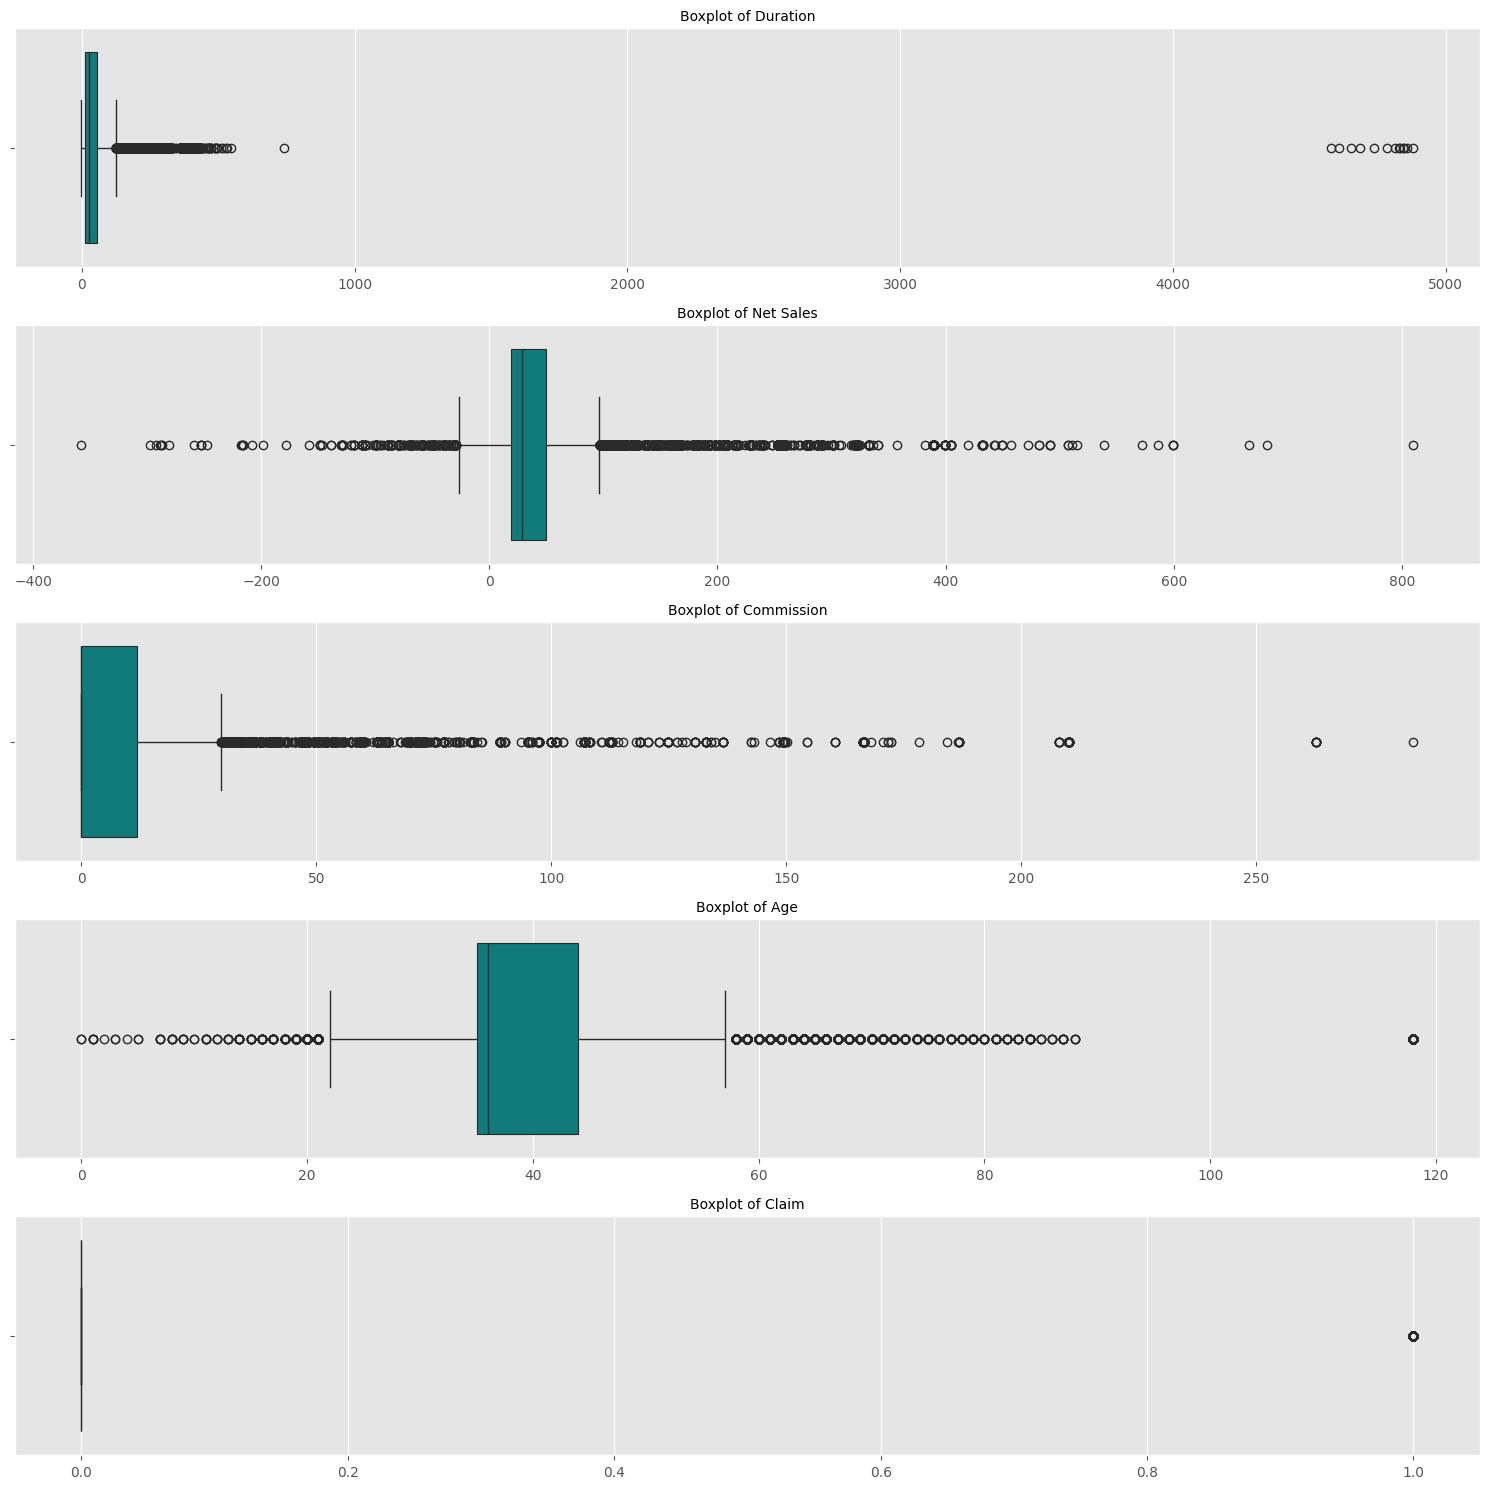

In [128]:
# mengambil kolom numerik
numerical_columns = df.select_dtypes(include=['number']).columns

# Plot boxplot untuk setiap kolom numerik
plt.figure(figsize=(15, 15))

# Iterasi melalui setiap kolom numerik
for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(len(numerical_columns), 1, i)  # urutkan subplot secara vertikal
    sns.boxplot(x=df[column], color="darkcyan", 
                boxprops=dict(linewidth=0.8))  # boxplot transparan
    plt.title(f"Boxplot of {column}", fontsize=10) # judul boxplot
    plt.xlabel("")  # menghapus label sumbu x
    plt.tight_layout()  # mengatur layout agar lebih rapi

# melihat semua plot
plt.show()

In [129]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Duration,39324.0,52.275989,113.404932,-1.0,11.0,25.0,57.00,4881.0
Net Sales,39324.0,42.202530,49.704030,-357.5,19.0,29.0,50.00,810.0
Commission,39324.0,10.386189,20.345275,0.0,0.0,0.0,11.88,283.5
Age,39324.0,39.833054,13.225494,0.0,35.0,36.0,44.00,118.0
Claim,39324.0,0.017114,0.129699,0.0,0.0,0.0,0.00,1.0


In [130]:
# cara mengambil yang numerik aja
numerik = df.select_dtypes(include='number') # yg mengandung integer dan float akan masuk
numerik

,Duration,Net Sales,Commission,Age,Claim
0,365,216.0,54.00,57,0
1,4,10.0,0.00,33,0
2,19,22.0,7.70,26,0
3,20,112.0,0.00,59,0
4,8,16.0,4.00,28,0
...,...,...,...,...,...
39319,14,30.0,0.00,36,1
39320,17,79.2,47.52,47,0
39321,64,30.0,10.50,50,0
39322,51,36.0,0.00,36,0


In [131]:
# uji normalitas kolom numerik menggunakan kstest
for nama_kolom in numerik.columns:
    stat, pval = kstest(df[nama_kolom], 'norm')
    if pval < 0.05:
        print(f'Kolom {nama_kolom} Distribusi tidak normal (Tolak H0)')
    else:
        print(f'Kolom {nama_kolom}Distribusi normal (Terima H0)')

Kolom Duration Distribusi tidak normal (Tolak H0)
Kolom Net Sales Distribusi tidak normal (Tolak H0)
Kolom Commission Distribusi tidak normal (Tolak H0)
Kolom Age Distribusi tidak normal (Tolak H0)
Kolom Claim Distribusi tidak normal (Tolak H0)


In [132]:
# mengetahui jumlah outlier menggunakan IQR * 1.5
for nama_kolom in numerik.columns:
    q3 = df[nama_kolom].quantile(0.75)
    q1 = df[nama_kolom].quantile(0.25)
    iqr = q3 - q1
    batas_atas = q3 + (iqr * 1.5)
    batas_bawah = q1 - (iqr * 1.5)
    jumlah_outliers = len(df[(df[nama_kolom] > batas_atas) | (df[nama_kolom] < batas_bawah)])
    print(f'Jumlah Outliers {nama_kolom}: {jumlah_outliers}')

Jumlah Outliers Duration: 3444
Jumlah Outliers Net Sales: 3543
Jumlah Outliers Commission: 4028
Jumlah Outliers Age: 3741
Jumlah Outliers Claim: 673


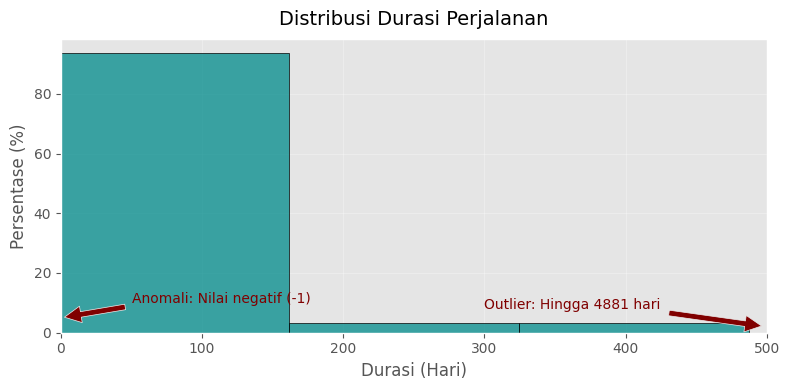

In [133]:
# Set style
plt.style.use('ggplot')

# Buat histogram untuk Duration
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='Duration', bins=30, stat='percent', color='darkcyan', edgecolor='black')
plt.title('Distribusi Durasi Perjalanan', fontsize=14, pad=10)
plt.xlabel('Durasi (Hari)', fontsize=12)
plt.ylabel('Persentase (%)', fontsize=12)
plt.xlim(0, 500)  # Batasi untuk fokus pada sebagian besar data (hindari outlier ekstrem)
plt.grid(True, alpha=0.3)

# Tambahkan anotasi untuk anomali
plt.annotate('Anomali: Nilai negatif (-1)', xy=(0, 5), xytext=(50, 10),
             arrowprops=dict(facecolor='maroon', shrink=0.05), fontsize=10, color='maroon')
plt.annotate('Outlier: Hingga 4881 hari', xy=(500, 2), xytext=(300, 8),
             arrowprops=dict(facecolor='maroon', shrink=0.05), fontsize=10, color='maroon')

# Simpan grafik
plt.tight_layout()
plt.savefig('duration_histogram.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

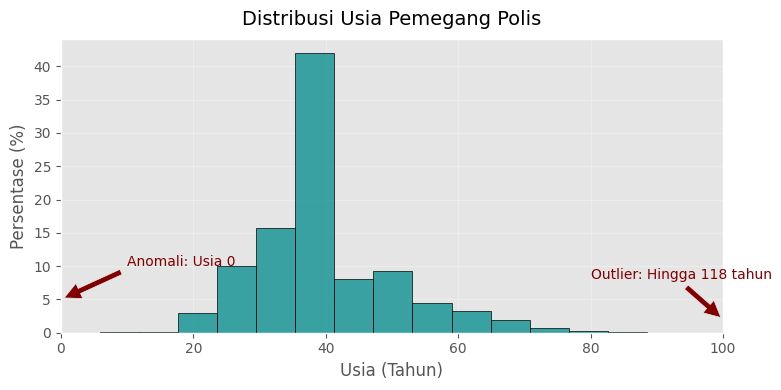

In [134]:
# Set style
plt.style.use('ggplot')

# Buat histogram untuk Age
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='Age', bins=20, stat='percent', color='darkcyan', edgecolor='black')
plt.title('Distribusi Usia Pemegang Polis', fontsize=14, pad=10)
plt.xlabel('Usia (Tahun)', fontsize=12)
plt.ylabel('Persentase (%)', fontsize=12)
plt.xlim(0, 100)  # Batasi untuk fokus pada rentang usia realistis
plt.grid(True, alpha=0.3)

# Tambahkan anotasi untuk anomali
plt.annotate('Anomali: Usia 0', xy=(0, 5), xytext=(10, 10),
             arrowprops=dict(facecolor='maroon', shrink=0.05), fontsize=10, color='maroon')
plt.annotate('Outlier: Hingga 118 tahun', xy=(100, 2), xytext=(80, 8),
             arrowprops=dict(facecolor='maroon', shrink=0.05), fontsize=10, color='maroon')

# Simpan grafik
plt.tight_layout()
plt.savefig('age_histogram.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Handling Outlier

In [135]:
# Sebelum pembersihan
print("Sebelum pembersihan outlier:")
print(df[['Duration', 'Net Sales', 'Commission', 'Age']].describe())
print("Distribusi Claim sebelum pembersihan:")
print(df['Claim'].value_counts(normalize=True))

# Hitung jumlah baris awal
initial_rows = len(df)
print(f"Jumlah baris awal: {initial_rows}")

# Pembersihan outlier
df_clean = df[
    (df['Net Sales'] > 0) &  # Net Sales > 0
    (df['Age'] >= 0) & (df['Age'] <= 90) &  # Age 0-90 year
    (df['Duration'] >= 0) & (df['Duration'] <= 547) &  # Duration 0-547
    (df['Commission'] > 0)  # Commission > 0
].reset_index(drop=True)

# Setelah pembersihan
print("\nSetelah pembersihan outlier:")
print(df_clean[['Duration', 'Net Sales', 'Commission', 'Age']].describe())
print("Distribusi Claim setelah pembersihan:")
print(df_clean['Claim'].value_counts(normalize=True))

# Hitung jumlah baris yang dihapus
final_rows = len(df_clean)
print(f"\nJumlah baris setelah pembersihan: {final_rows}")
print(f"Baris yang dihapus: {initial_rows - final_rows}")

Sebelum pembersihan outlier:
           Duration    Net Sales    Commission           Age
count  39324.000000  39324.00000  39324.000000  39324.000000
mean      52.275989     42.20253     10.386189     39.833054
std      113.404932     49.70403     20.345275     13.225494
min       -1.000000   -357.50000      0.000000      0.000000
25%       11.000000     19.00000      0.000000     35.000000
50%       25.000000     29.00000      0.000000     36.000000
75%       57.000000     50.00000     11.880000     44.000000
max     4881.000000    810.00000    283.500000    118.000000
Distribusi Claim sebelum pembersihan:
Claim
0    0.982886
1    0.017114
Name: proportion, dtype: float64
Jumlah baris awal: 39324

Setelah pembersihan outlier:
           Duration     Net Sales    Commission           Age
count  16630.000000  16630.000000  16630.000000  16630.000000
mean      59.301082     55.493441     21.766961     41.499519
std       94.693141     64.195799     24.982832     12.767552
min        0.0

<Figure size 2000x1500 with 0 Axes>

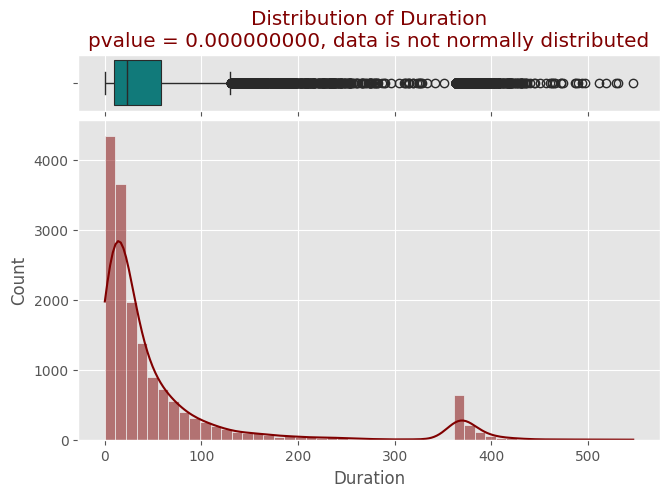

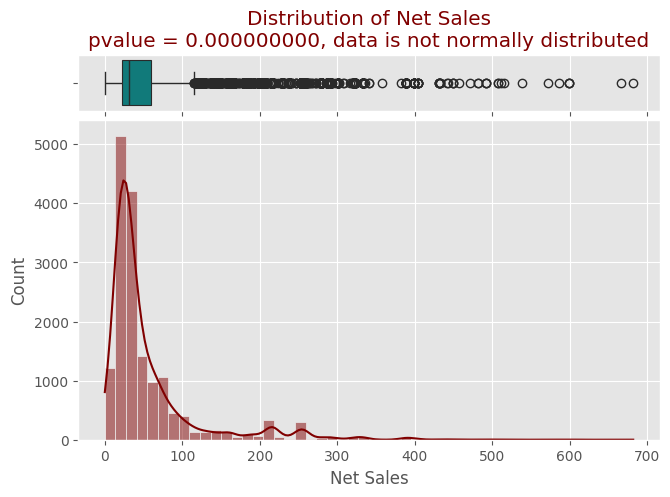

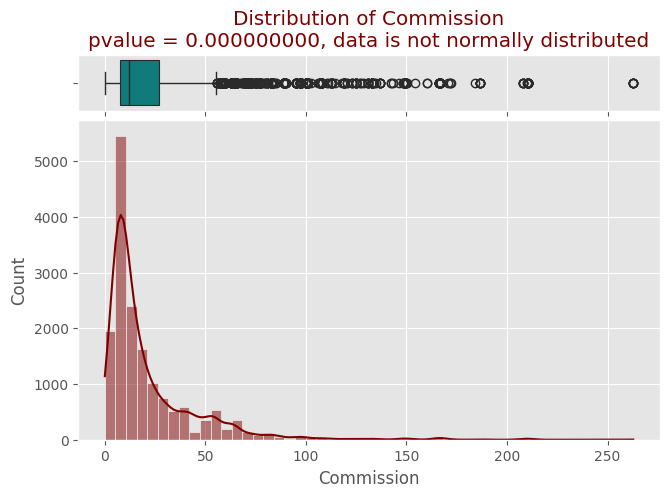

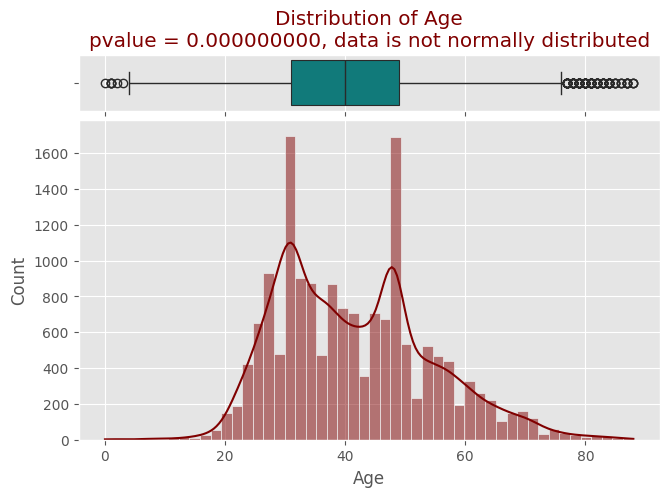

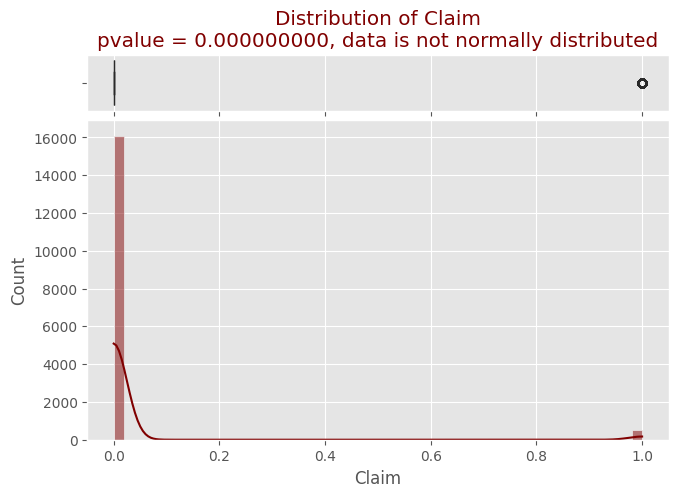

In [136]:
# mengambil kolom numerik
numerical_columns = df_clean.select_dtypes(include=['number']).columns

# plot boxplot untuk setiap kolom numerik
plt.figure(figsize=(20,15))

for column in numerical_columns:

    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(7.5,5), 
                                    gridspec_kw={"height_ratios": (.15, .85), "hspace": 0.05})

    # Perform normality test (normaltest)
    stat, pvalue = normaltest(df[column].dropna())

    # Determine normality based on p-value
    if pvalue > 0.05:
        distribution = f'pvalue = {pvalue:.9f}, data is normally distributed'
    else:
        distribution = f'pvalue = {pvalue:.9f}, data is not normally distributed'

    # Set title with result of normality test
    ax1.set_title(f"Distribution of {column}\n{distribution}", color="maroon")

    # boxplot untuk setiap kolom numerik dengan background transparan
    sns.boxplot(x=df_clean[column], ax=ax1, color="darkcyan", 
                boxprops=dict(linewidth=0.8))  # Transparent boxplot
    ax1.set(xlabel="")

    # Histogram and KDE for the column
    sns.histplot(df_clean[column], ax=ax2, stat="count", kde=True, bins=50, color="maroon",)

# Show all plots after finishing the loop
plt.show()

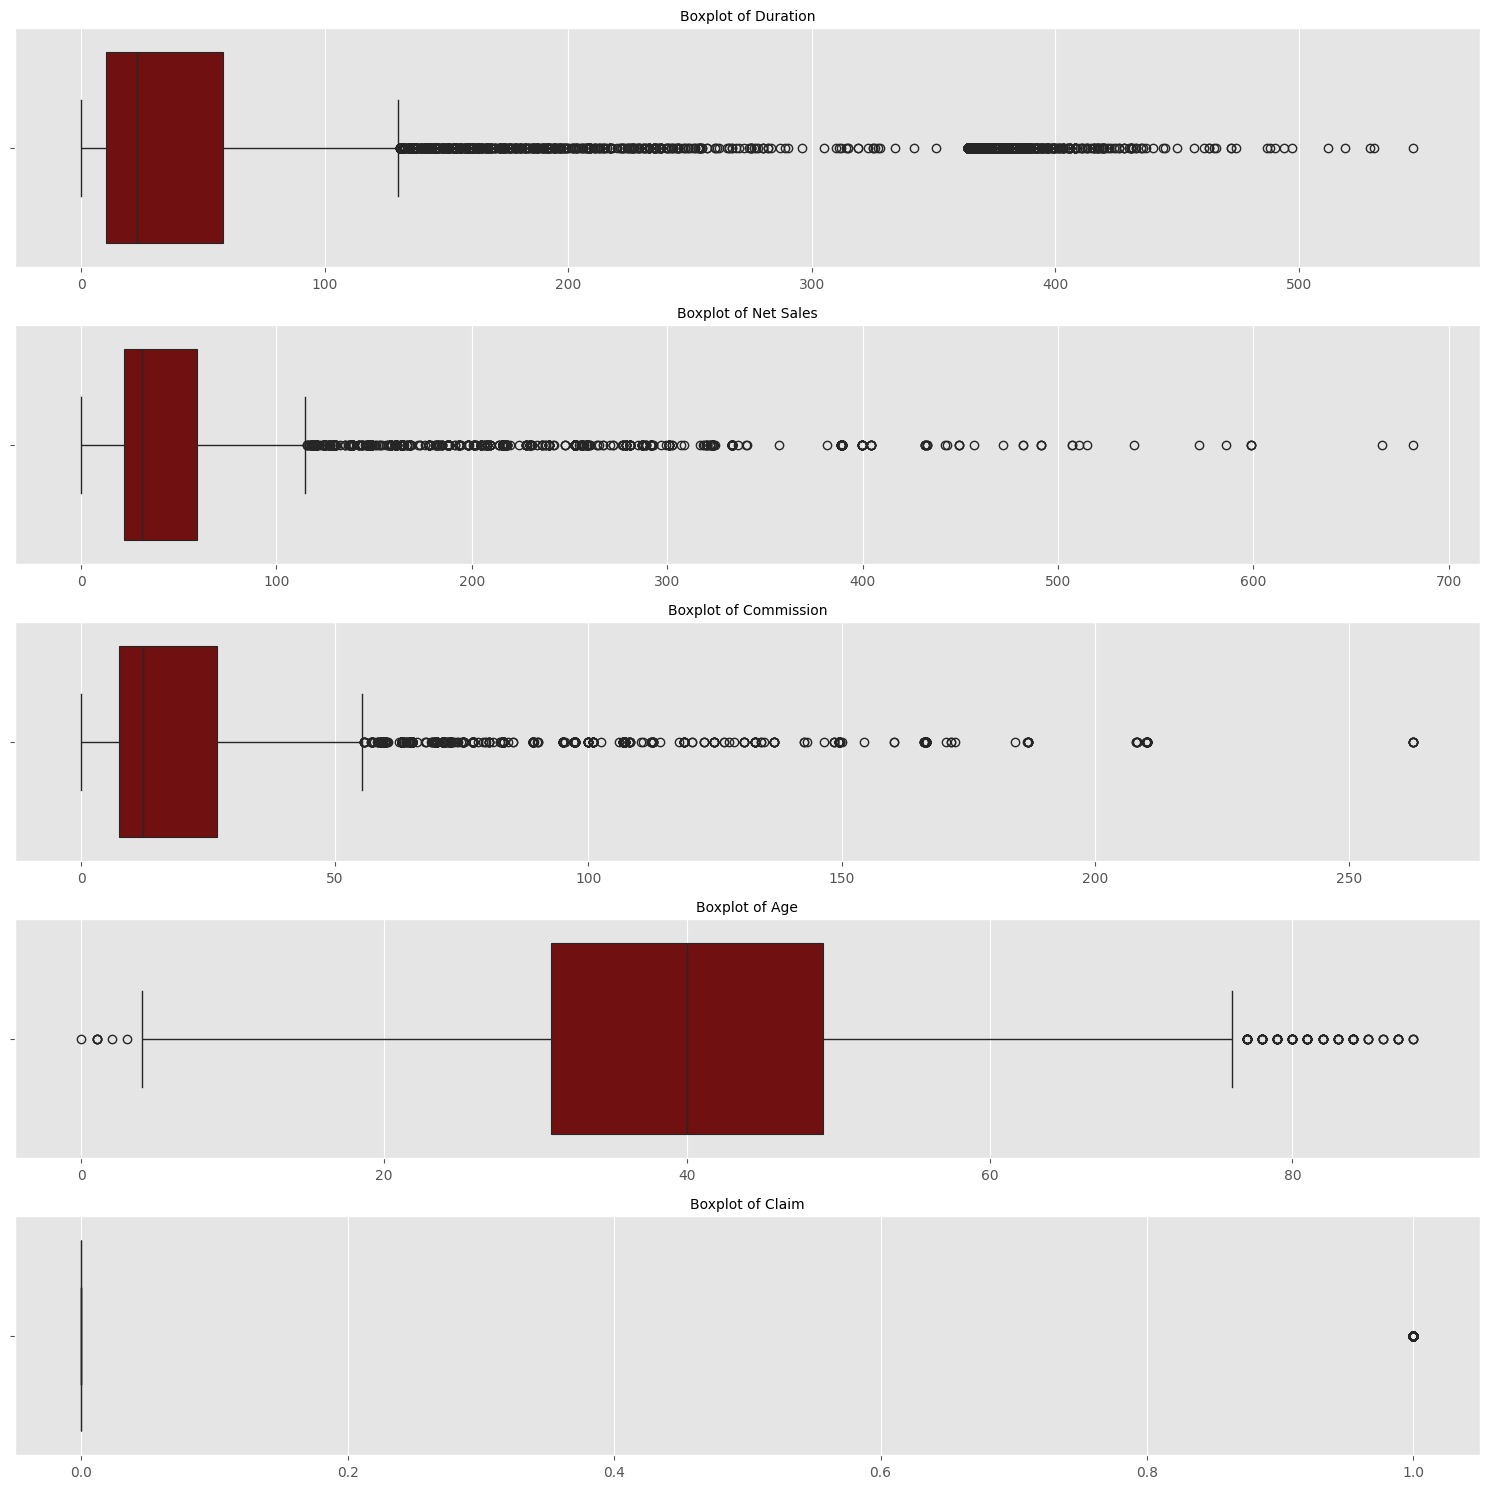

In [137]:
# mengambil kolom numerik
numerical_columns = df_clean.select_dtypes(include=['number']).columns

# Plot boxplot untuk setiap kolom numerik
plt.figure(figsize=(15, 15))

# Iterasi melalui setiap kolom numerik
for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(len(numerical_columns), 1, i)  # urutkan subplot secara vertikal
    sns.boxplot(x=df_clean[column], color="maroon", 
                boxprops=dict(linewidth=0.8))  # boxplot transparan
    plt.title(f"Boxplot of {column}", fontsize=10) # judul boxplot
    plt.xlabel("")  # menghapus label sumbu x
    plt.tight_layout()  # mengatur layout agar lebih rapi

# melihat semua plot
plt.show()

In [138]:
df_clean

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commission,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,0
1,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,0
2,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,0
3,JZI,Airlines,Online,Basic Plan,4,THAILAND,22.0,7.70,39,0
4,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,27,0
...,...,...,...,...,...,...,...,...,...,...
16625,JZI,Airlines,Online,Basic Plan,13,THAILAND,22.0,7.70,42,0
16626,JZI,Airlines,Online,Value Plan,11,UNITED KINGDOM,87.0,30.45,65,0
16627,TST,Travel Agency,Offline,Travel Cruise Protect,94,THAILAND,30.0,10.50,0,0
16628,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,0


## EDA

In [139]:
# Statistik deskriptif terpisah untuk Claim=0 dan Claim=1
df_clean.groupby('Claim').describe().T


Claim                        0           1
Duration   count  16096.000000  534.000000
           mean      57.320204  119.009363
           std       91.560513  151.367754
           min        0.000000    2.000000
           25%       10.000000   13.000000
           50%       23.000000   33.000000
           75%       56.250000  364.000000
           max      547.000000  431.000000
Net Sales  count  16096.000000  534.000000
           mean      53.874131  104.303202
           std       62.009036   99.982774
           min        0.190000    4.760000
           25%       22.000000   29.500000
           50%       30.000000   57.950000
           75%       59.400000  187.850000
           max      682.000000  507.000000
Commission count  16096.000000  534.000000
           mean      21.415680   32.355393
           std       24.579952   33.350109
           min        0.050000    1.330000
           25%        7.380000    8.380000
           50%       11.880000   17.785000
           75%       24.380000   54.000000
           max      262.760000  210.210000
Age        count  16096.000000  534.000000
           mean      41.614003   38.048689
           std       12.761572   12.473968
           min        0.000000   14.000000
           25%       31.000000   29.000000
           50%       40.000000   35.000000
           75%       49.000000   46.000000
           max       88.000000   81.000000

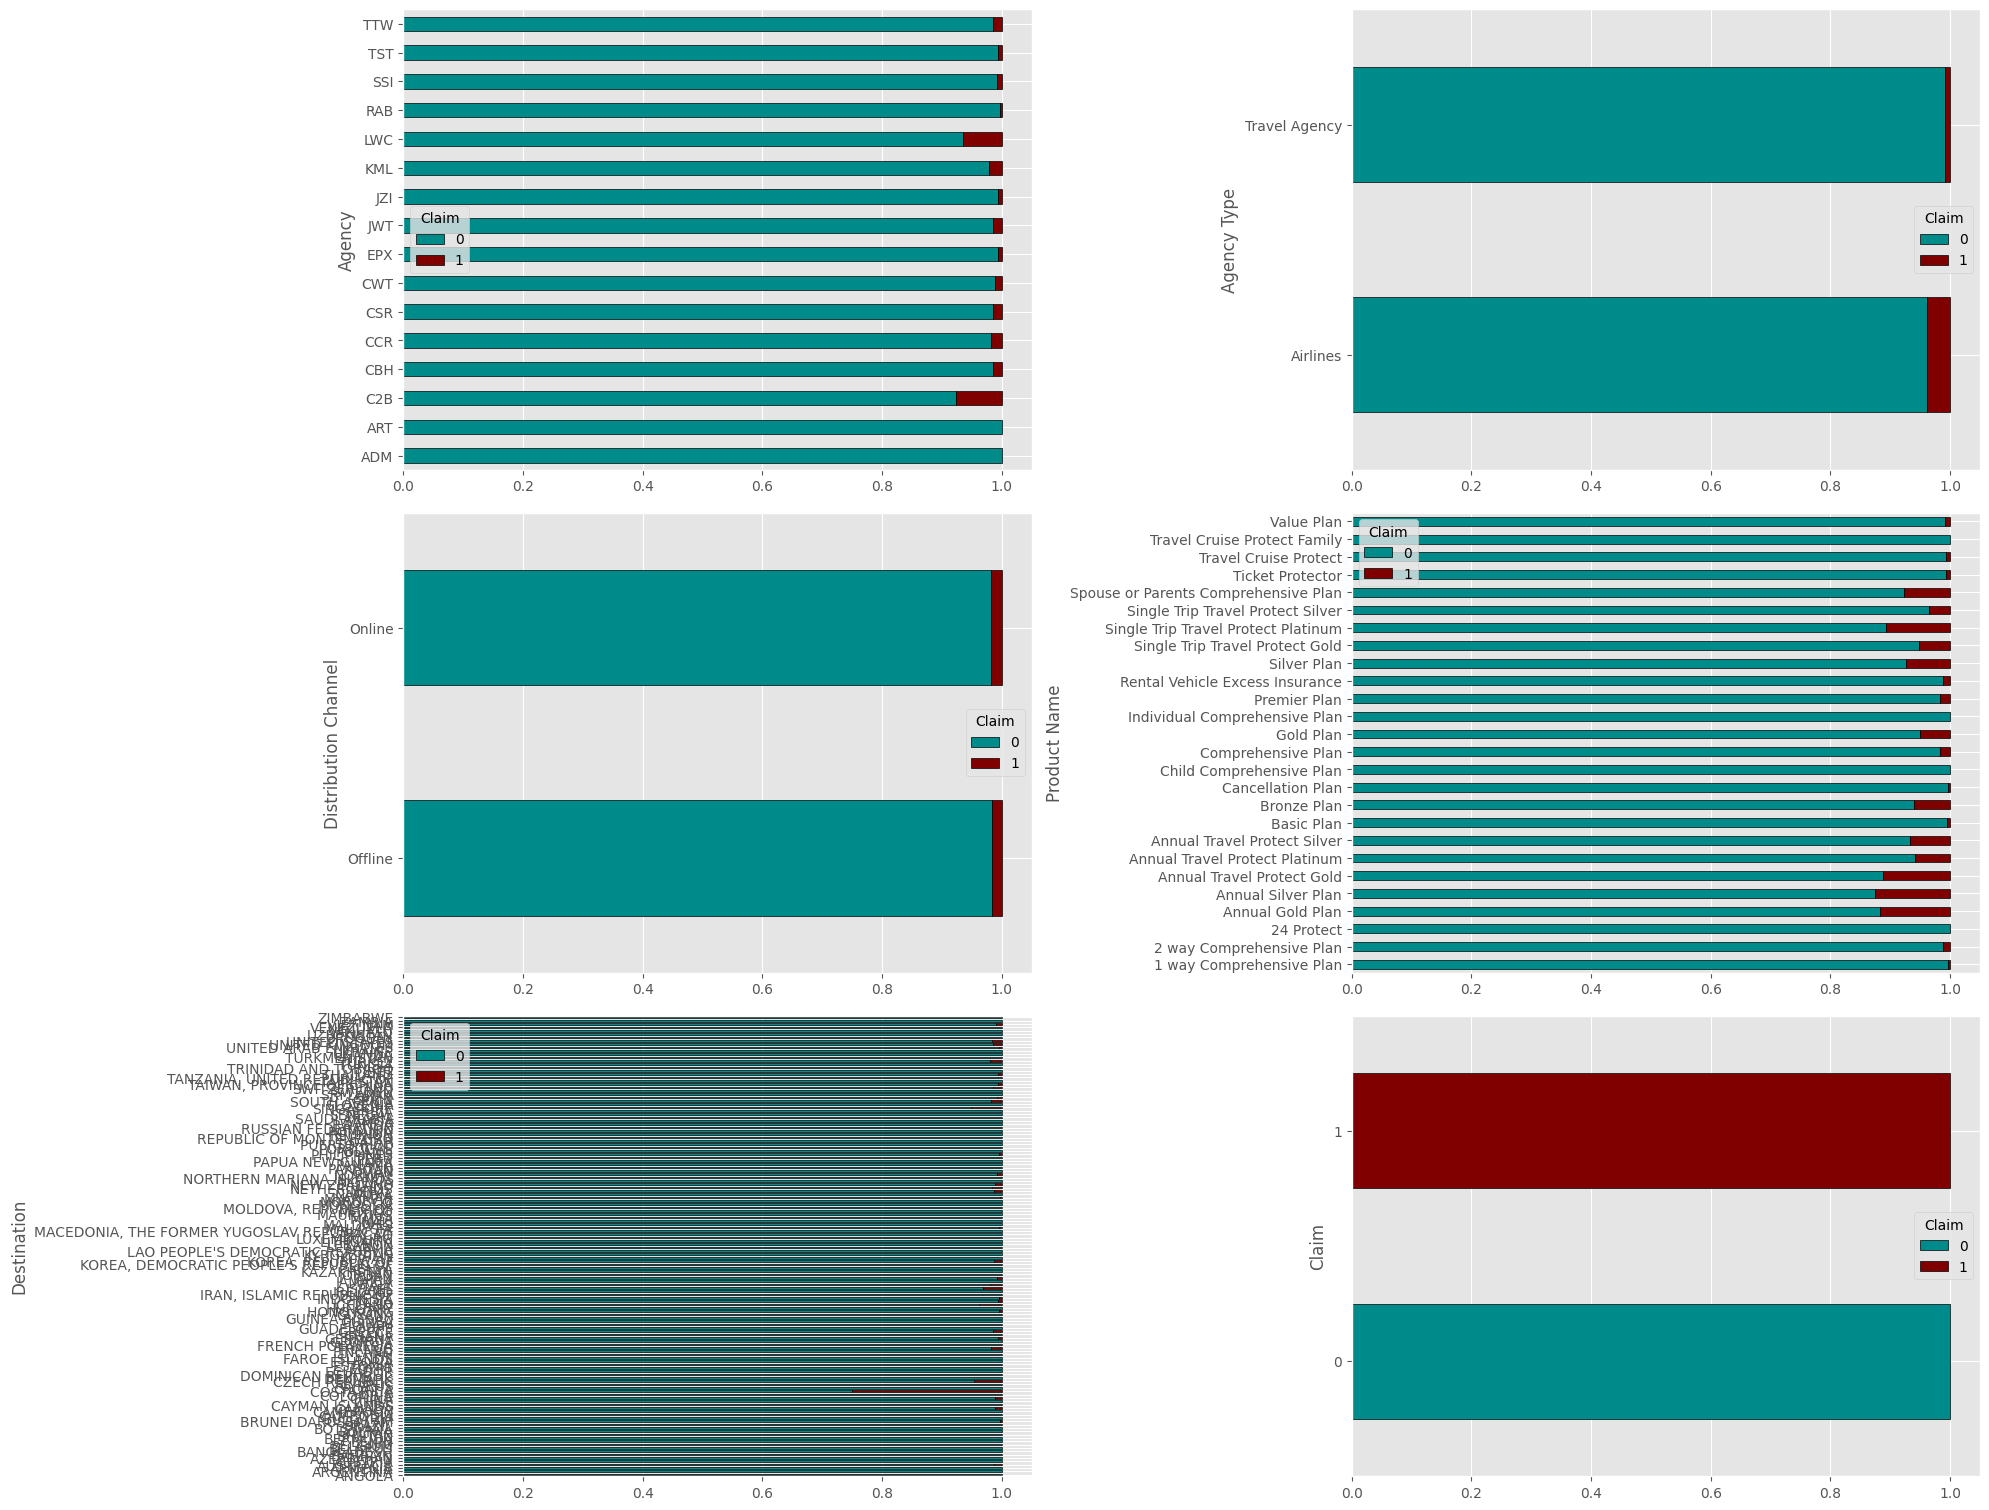

In [140]:
# menampilkan distribusi setiap kolom terhadap predikat claim
count = 0
fig = plt.figure(figsize=(20,20))

for i in df_clean.drop(columns=['Duration','Net Sales','Commission','Age']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df[i],df['Claim'], normalize=0).plot(kind='barh', stacked=True,ax=ax,color=['darkcyan','maroon'], edgecolor='black')
    fig.tight_layout()

plt.tight_layout()
plt.show()

In [141]:
# telusuri pengaruh kolom-kolom tertentu pada predikat claim yg sedang dianalisa
for i in df_clean.drop(columns=['Duration','Net Sales','Commission','Age']).columns:
    analysis_df = df_clean.groupby([i, 'Claim']).size().div(df.groupby(i).size(), level=0).unstack(fill_value=0)
    display(analysis_df.sort_values(by=[1.0], ascending=False)) # 1.0 = Claim = 1

Claim,0,1
Agency,,
C2B,0.901387,0.075553
LWC,0.893805,0.064159
KML,0.969432,0.021834
CBH,0.910448,0.014925
CSR,0.985294,0.014706
CWT,0.823437,0.011177
CCR,0.807018,0.008772
SSI,0.964838,0.007032
TST,0.969605,0.006079


Claim,0,1
Agency Type,,
Airlines,0.906751,0.038386
Travel Agency,0.210528,0.003666


Claim,0,1
Distribution Channel,,
Online,0.402688,0.013674
Offline,0.769339,0.008439


Claim,0,1
Product Name,,
Annual Silver Plan,0.844523,0.126031
Annual Gold Plan,0.816176,0.117647
Annual Travel Protect Gold,0.887097,0.112903
Single Trip Travel Protect Platinum,0.829787,0.106383
Silver Plan,0.910811,0.072973
Annual Travel Protect Silver,0.881356,0.067797
Bronze Plan,0.918755,0.060744
Annual Travel Protect Platinum,0.941176,0.058824
Single Trip Travel Protect Gold,0.902985,0.052239


Claim,0,1
Destination,,
SINGAPORE,0.683938,0.050333
ICELAND,0.666667,0.025641
CZECH REPUBLIC,0.255814,0.023256
SOUTH AFRICA,0.504425,0.017699
GREECE,0.547945,0.013699
...,...,...
TUNISIA,0.142857,0.000000
UNITED ARAB EMIRATES,0.376238,0.000000
TURKMENISTAN,1.000000,0.000000


Claim,0,1
Claim,,
1,0.000000,0.793462
0,0.416445,0.000000


**Kesimpulan Tabel**
- Claim paling banyak ditemukan pada agensi C2B 0.075, LWC 0.064, KML 0.021, CBH 0.0149. Untuk agensi ADM dan ART tidak ada Claim yang ditemukan.
- Claim paling banyak ditemukan pada agensi yang bergerak di bidang penerbangan yakni 0.038 dibandingkan agen travel perjalanan yang hanya 0.003.
- Claim paling banyak dilakukan oleh para pelaku atau orang yang melakukan perjalanan di mana mereka melakukan distribusi claim itu secara Online 0.013 dibandingkan Offline atau tatap muka 0.008.
- Ada 5 produk dengan Claim tinggi yakni Annual Silver Plan 0.126, Annual Gold Plan 0.117, Annual Travel Protect Gold 0.112, Single Trip Travel Protect Platinum 0.106, dan Silver Plan 0.072. Kelima produk ini sering dipilih atau digunakan untuk perjalanan jangka panjang.
- Ada 5 destinasi negara dengan Claim tinggi yang sering dipilih oleh para pelaku perjalanan yakni Singapura 0.050, Islandia 0.025, Republik Ceko 0.023, Afrika Selatan 0.017, dan Yunani 0.013.

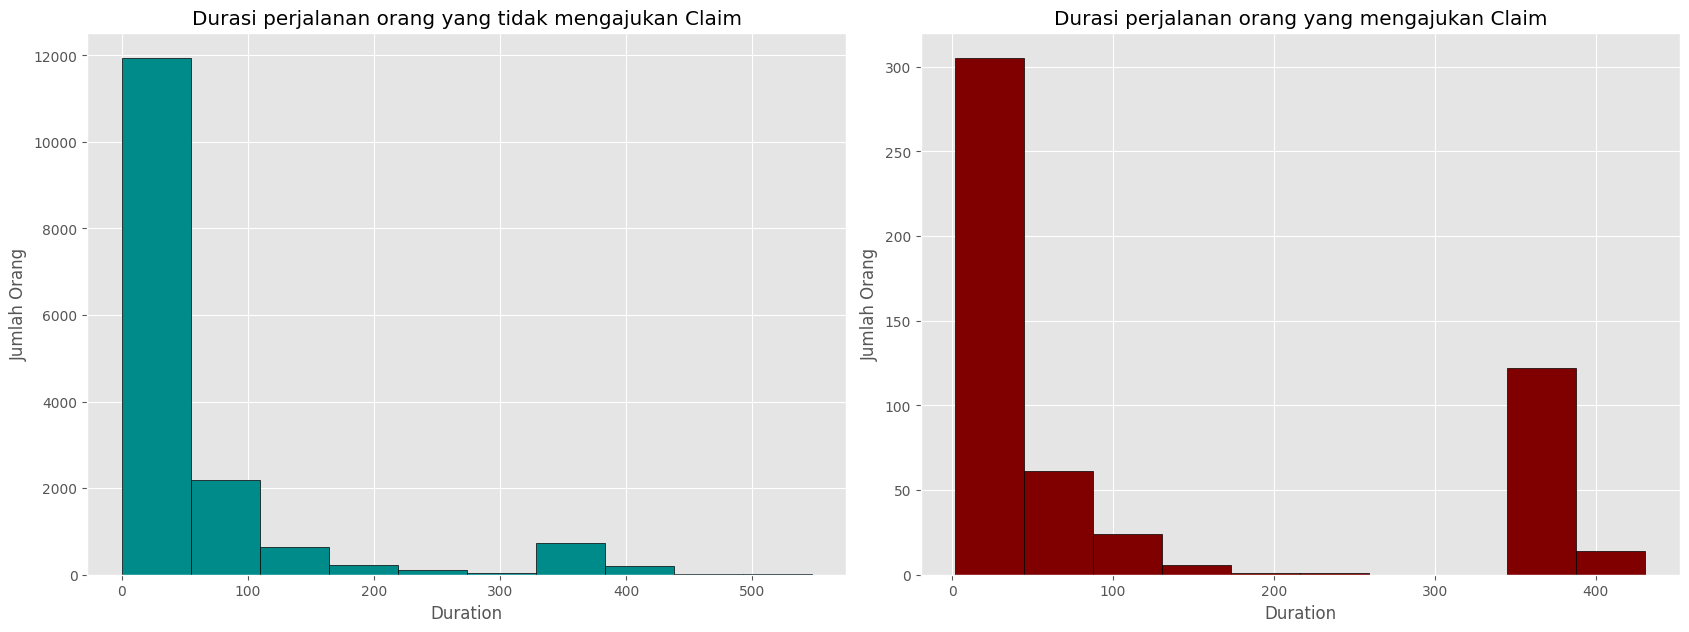

In [142]:
plt.figure(figsize=(17,12))

plt.subplot(221)
plt.hist(df_clean[df_clean['Claim']==0]['Duration'], color='darkcyan', edgecolor='black')
plt.xlabel('Duration')
plt.ylabel('Jumlah Orang')
plt.title('Durasi perjalanan orang yang tidak mengajukan Claim')

plt.subplot(222)
plt.hist(df_clean[df_clean['Claim']==1]['Duration'], color='maroon', edgecolor='black')
plt.xlabel('Duration')
plt.ylabel('Jumlah Orang')
plt.title('Durasi perjalanan orang yang mengajukan Claim')

plt.tight_layout()
plt.show()

1. Histogram Kiri: Durasi Perjalanan Orang yang Tidak Mengajukan Klaim (Claim = 0)

- Pola Distribusi:
    - Sebagian besar durasi perjalanan terkonsentrasi di bawah 100 hari, dengan puncak tertinggi di sekitar 0 hingga 50 hari (frekuensi mendekati 12.000 orang).
    - Ada penurunan tajam setelah 100 hari, dengan beberapa individu melakukan perjalanan hingga 500 hari, tetapi frekuensinya sangat kecil.

- Rentang Durasi:
    - Mayoritas perjalanan berdurasi pendek (0–100 hari).
    - Ada beberapa outlier dengan durasi sangat panjang (mendekati 500 hari), tetapi jumlahnya sangat sedikit.

- Insight:
    - Orang yang tidak mengajukan klaim cenderung melakukan perjalanan dengan durasi pendek (kurang dari 100 hari).
    - Perjalanan berdurasi sangat panjang (lebih dari 400 hari) jarang terjadi pada kelompok ini.

2. Histogram Kanan: Durasi Perjalanan Orang yang Mengajukan Klaim (Claim = 1)

- Pola Distribusi:
    - Sebagian besar durasi perjalanan juga terkonsentrasi di bawah 100 hari, dengan puncak tertinggi di sekitar 0 hingga 50 hari (frekuensi mendekati 300 orang).
    - Ada penurunan setelah 100 hari, tetapi terlihat beberapa individu dengan durasi perjalanan yang lebih panjang, termasuk puncak kecil di sekitar 400 hari (frekuensi sekitar 150 orang).

- Rentang Durasi:
    - Seperti kelompok Claim = 0, mayoritas perjalanan berdurasi pendek (0–100 hari).
    - Namun, ada kelompok yang cukup signifikan dengan durasi perjalanan sekitar 400 hari, yang tidak terlihat pada kelompok Claim = 0.

- Insight:
    - Orang yang mengajukan klaim juga mayoritas melakukan perjalanan dengan durasi pendek (0–100 hari), tetapi ada kecenderungan lebih banyak klaim pada perjalanan berdurasi sangat panjang (sekitar 400 hari).
    - Puncak di sekitar 400 hari menunjukkan bahwa perjalanan jangka panjang mungkin memiliki risiko lebih tinggi untuk mengajukan klaim.

**--------------------------------------------------------------------------------------------------------------------------------------------------------**

- Kesamaan:
    - Baik pada kelompok Claim = 0 maupun Claim = 1, mayoritas perjalanan berdurasi pendek (0–100 hari). Ini menunjukkan bahwa sebagian besar pelancong dalam dataset ini melakukan perjalanan singkat, terlepas dari apakah mereka mengajukan klaim atau tidak.

- Perbedaan:
    - Skala Frekuensi: Histogram kiri (Claim = 0) memiliki frekuensi yang jauh lebih besar (puncak hingga 12.000 orang) dibandingkan histogram kanan (Claim = 1, puncak hanya 300 orang). Ini mencerminkan ketidakseimbangan kelas yang signifikan (98,47% "No" vs 1,53% "Yes") seperti yang disebutkan dalam notebook.
    - Durasi Panjang: Pada kelompok Claim = 1, terdapat puncak kecil tapi signifikan di sekitar 400 hari, yang tidak terlihat pada kelompok Claim = 0. Ini menunjukkan bahwa perjalanan dengan durasi sangat panjang (sekitar 400 hari) memiliki kemungkinan lebih tinggi untuk mengajukan klaim.
    - Proporsi Klaim pada Durasi Panjang: Jika kita bandingkan proporsi, perjalanan berdurasi panjang (misalnya, 400 hari) memiliki rasio klaim yang lebih tinggi dibandingkan perjalanan berdurasi pendek.


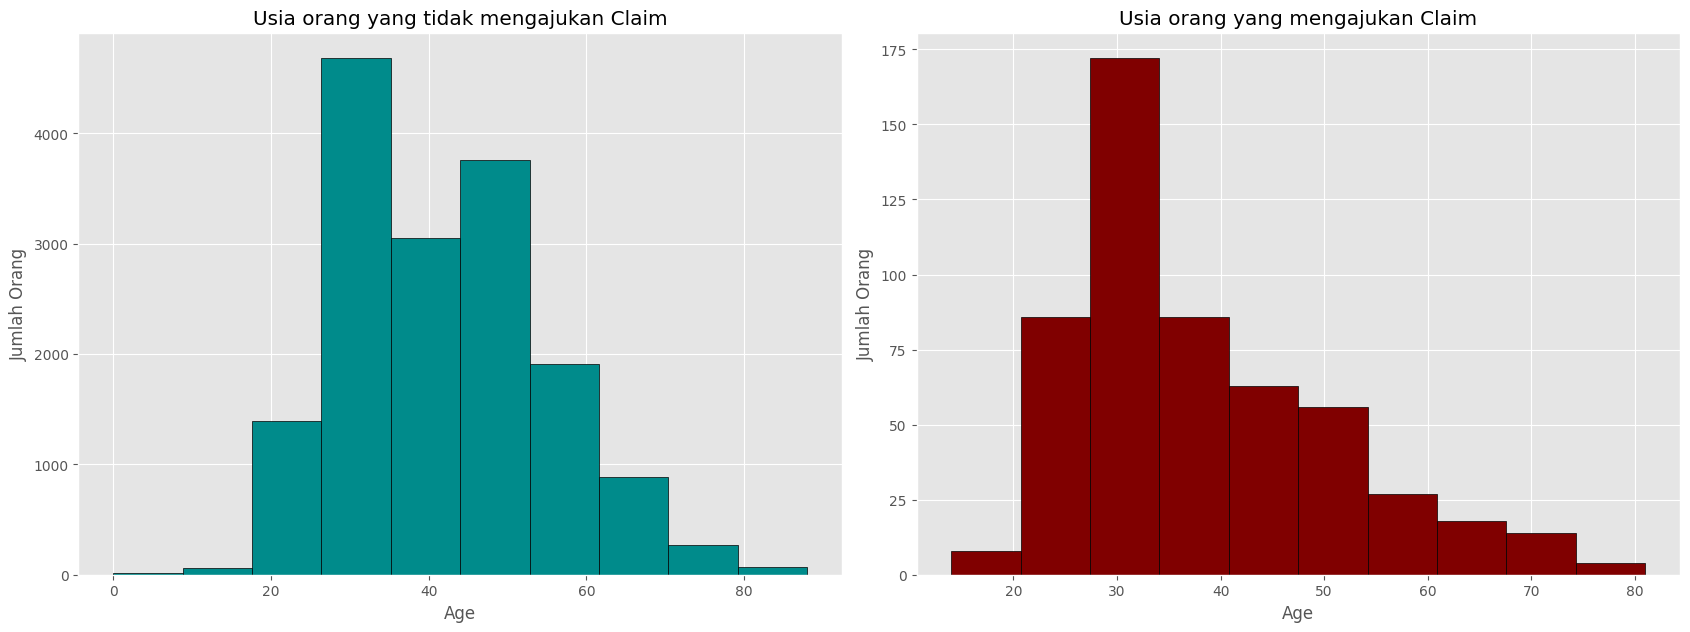

In [143]:
plt.figure(figsize=(17,12))

plt.subplot(221)
plt.hist(df_clean[df_clean['Claim']==0]['Age'], color='darkcyan', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Jumlah Orang')
plt.title('Usia orang yang tidak mengajukan Claim')

plt.subplot(222)
plt.hist(df_clean[df_clean['Claim']==1]['Age'], color='maroon', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Jumlah Orang')
plt.title('Usia orang yang mengajukan Claim')

plt.tight_layout()
plt.show()

1. Histogram Kiri: Usia Orang yang Tidak Mengajukan Klaim (Claim = 0)
- Pola Distribusi:
    - Sebagian besar usia terkonsentrasi antara 30 hingga 50 tahun, dengan puncak tertinggi di sekitar 35–40 tahun (frekuensi mendekati 4.500 orang).
    - Distribusi menyerupai bentuk lonceng (distribusi normal) dengan sedikit kemiringan ke kanan.
    - Ada jumlah kecil individu dengan usia di bawah 20 tahun dan di atas 60 tahun.
    - Usia maksimum terlihat hingga sekitar 80 tahun, tetapi frekuensinya sangat kecil.

- Rentang Usia:
    - Mayoritas pelancong berusia 30–50 tahun.
    - Ada beberapa outlier dengan usia sangat muda (di bawah 20 tahun) atau sangat tua (di atas 70 tahun), tetapi jumlahnya sedikit.

- Insight:
    - Orang yang tidak mengajukan klaim cenderung berada pada rentang usia produktif, terutama 30–50 tahun, yang mungkin mencerminkan demografi pelancong bisnis atau wisatawan keluarga.
    - Usia ekstrem (sangat muda atau sangat tua) jarang terjadi pada kelompok ini.

2. Histogram Kanan: Usia Orang yang Mengajukan Klaim (Claim = 1)
- Pola Distribusi:
    - Sebagian besar usia juga terkonsentrasi antara 30 hingga 50 tahun, dengan puncak tertinggi di sekitar 35–40 tahun (frekuensi mendekati 175 orang).
    - Distribusi ini juga menyerupai bentuk lonceng, tetapi dengan kemiringan ke kanan yang lebih jelas dibandingkan histogram kiri.
    - Ada lebih banyak individu dengan usia di atas 50 tahun dibandingkan histogram kiri, meskipun frekuensinya tetap kecil.
    - Usia maksimum juga terlihat hingga sekitar 80 tahun.

- Rentang Usia:
    - Mayoritas pelancong yang mengajukan klaim berusia 30–50 tahun, mirip dengan kelompok Claim = 0.
    - Namun, ada distribusi yang lebih merata untuk usia di atas 50 tahun dibandingkan kelompok Claim = 0.

- Insight:
    - Orang yang mengajukan klaim juga mayoritas berada pada rentang usia 30–50 tahun, tetapi ada kecenderungan lebih banyak klaim dari pelancong yang lebih tua (di atas 50 tahun) dibandingkan kelompok yang tidak mengajukan klaim.
    - Usia di atas 50 tahun tampaknya memiliki risiko klaim yang lebih tinggi, mungkin karena faktor kesehatan atau kebutuhan asuransi yang lebih besar pada kelompok usia ini.

**-------------------------------------------------------------------------------------------------------------------------------------------**

- Kesamaan:
    - Baik pada kelompok Claim = 0 maupun Claim = 1, mayoritas pelancong berusia antara 30 hingga 50 tahun. Ini menunjukkan bahwa demografi pelancong dalam dataset ini didominasi oleh usia produktif, terlepas dari status klaim.
    - Kedua histogram menunjukkan distribusi yang mirip dengan bentuk lonceng (distribusi normal), dengan puncak di sekitar 35–40 tahun.

- Perbedaan:
    - Skala Frekuensi: Histogram kiri (Claim = 0) memiliki frekuensi yang jauh lebih besar (puncak hingga 4.500 orang) dibandingkan histogram kanan (Claim = 1, puncak hanya 175 orang). Ini mencerminkan ketidakseimbangan kelas yang signifikan (98,47% "No" vs 1,53% "Yes") seperti yang disebutkan dalam notebook.
    - Distribusi Usia Tua: Histogram kanan (Claim = 1) menunjukkan distribusi yang lebih merata untuk usia di atas 50 tahun dibandingkan histogram kiri. Ini menunjukkan bahwa pelancong yang lebih tua (di atas 50 tahun) cenderung lebih sering mengajukan klaim.
    - Proporsi Klaim pada Usia Tua: Jika kita bandingkan proporsi, pelancong dengan usia di atas 50 tahun memiliki rasio klaim yang lebih tinggi dibandingkan pelancong yang lebih muda. Hal ini terlihat dari distribusi yang lebih merata pada histogram kanan untuk usia 50–80 tahun.

In [144]:
df_clean

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commission,Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,0
1,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,0
2,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,0
3,JZI,Airlines,Online,Basic Plan,4,THAILAND,22.0,7.70,39,0
4,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,27,0
...,...,...,...,...,...,...,...,...,...,...
16625,JZI,Airlines,Online,Basic Plan,13,THAILAND,22.0,7.70,42,0
16626,JZI,Airlines,Online,Value Plan,11,UNITED KINGDOM,87.0,30.45,65,0
16627,TST,Travel Agency,Offline,Travel Cruise Protect,94,THAILAND,30.0,10.50,0,0
16628,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,0


# Data Preparation

## Data Splitting dan Feature Engineering

In [145]:
# pisahkan fitur (X) dan target (y)
X = df_clean.drop(columns=["Claim"])
y = df_clean["Claim"] # kolom target

# split data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13304, 9), (3326, 9), (13304,), (3326,))

In [146]:
df_clean['Age_group'] = pd.qcut(df_clean['Age'], q=4, labels=['Child', 'Young', 'Adult', 'Old'])
df_clean.drop(columns=['Age'], inplace=True)

In [147]:
df_clean['Net_Sales_group'] = pd.qcut(df_clean['Net Sales'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
df_clean.drop(columns=['Net Sales'], inplace=True)


In [148]:
df_clean

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Commission,Claim,Age_group,Net_Sales_group
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,54.00,0,Old,Very High
1,JZI,Airlines,Online,Basic Plan,19,INDIA,7.70,0,Child,Low
2,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,4.00,0,Child,Low
3,JZI,Airlines,Online,Basic Plan,4,THAILAND,7.70,0,Young,Low
4,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,54.00,0,Child,Very High
...,...,...,...,...,...,...,...,...,...,...
16625,JZI,Airlines,Online,Basic Plan,13,THAILAND,7.70,0,Adult,Low
16626,JZI,Airlines,Online,Value Plan,11,UNITED KINGDOM,30.45,0,Old,Very High
16627,TST,Travel Agency,Offline,Travel Cruise Protect,94,THAILAND,10.50,0,Child,Medium
16628,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,47.52,0,Adult,Very High


In [149]:
def num_pipe(impute='median', poly=None, scaling=None, n_neighbors=5,
             max_iter=10, weights="uniform"):

  # pastikan parameter diatas diinput dengan benar
  if impute not in ['knn', 'mean', 'median', 'iterative', None]:
    raise Exception("impute only supports {'knn', 'mean', 'median', None}")
  if scaling not in ['standard', 'minmax', 'robust', 'maxabs', 'normalize', None]:
    raise Exception("scaling only supports {'standard', 'minmax', 'robust', 'maxabs', 'normalize'}")
  if (type(poly) is not int) and (poly is not None):
    raise Exception("poly should be int or None")

  # define imputer
  if impute is None:
    steps = []
  elif impute == "knn":
    steps = [('imputer', KNNImputer(n_neighbors=n_neighbors, weights=weights))]
  elif impute == "iterative":
    steps = [('imputer', IterativeImputer(max_iter=max_iter, random_state=0))]
  elif impute == "constant":
    steps = [('imputer', SimpleImputer(strategy=impute, fill_value="no_info"))]
  else:
    steps = [('imputer', SimpleImputer(strategy=impute))]

  # define poly jika digunakan
  if poly is not None:
    steps.append(('poly', PolynomialFeatures(poly)))

  # define scaling jika digunakan
  if scaling == 'standard':
    steps.append(('scaler', StandardScaler()))
  elif scaling == 'minmax':
    steps.append(('scaler', MinMaxScaler()))
  elif scaling == 'robust':
    steps.append(('scaler', RobustScaler()))

  return Pipeline(steps)

def cat_pipe(impute='most_frequent', encoder='onehot'):
  if impute not in ['most_frequent', 'constant', None]:
    raise Exception("impute only supports {'most_frequent', None}")
  if encoder not in ['onehot', 'ordinal', 'binary', None]:
    raise Exception("encoder should be boolean {'onehot', 'ordinal', 'binary', None}")

  if impute is None:
    steps = []
  else:
    steps = [('imputer', SimpleImputer(strategy=impute))]

  if encoder is not None:
    if encoder == 'onehot':
      steps.append(('onehot', OneHotEncoder(handle_unknown='ignore')))
    elif encoder == 'ordinal':
      steps.append(('ordinal', OrdinalEncoder()))
    elif encoder == 'binary':
      steps.append(('binary', BinaryEncoder()))

  return Pipeline(steps)

In [150]:
df_clean.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Commission', 'Claim', 'Age_group',
       'Net_Sales_group'],
      dtype='object')

In [151]:
df_clean

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Commission,Claim,Age_group,Net_Sales_group
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,54.00,0,Old,Very High
1,JZI,Airlines,Online,Basic Plan,19,INDIA,7.70,0,Child,Low
2,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,4.00,0,Child,Low
3,JZI,Airlines,Online,Basic Plan,4,THAILAND,7.70,0,Young,Low
4,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,54.00,0,Child,Very High
...,...,...,...,...,...,...,...,...,...,...
16625,JZI,Airlines,Online,Basic Plan,13,THAILAND,7.70,0,Adult,Low
16626,JZI,Airlines,Online,Value Plan,11,UNITED KINGDOM,30.45,0,Old,Very High
16627,TST,Travel Agency,Offline,Travel Cruise Protect,94,THAILAND,10.50,0,Child,Medium
16628,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,47.52,0,Adult,Very High


**RandomForest Classifier**

In [49]:
# klasifikasi kolom ke numerik, one-hot, ordinal, dan binary
numerik_cols = ['Duration', 'Commission']
one_hot_cols = ['Agency Type', 'Distribution Channel']
ordinal_cols = ['Age_group', 'Net_Sales_group']
binary_encode_cols = ['Agency', 'Product Name', 'Destination']

# Pipeline kategorik untuk one-hot dan ordinal encoding
numeric_pipeline = num_pipe(scaling='robust')
onehot_pipeline = cat_pipe(encoder="onehot")
ordinal_pipeline = cat_pipe(encoder="ordinal")
binary_pipeline = cat_pipe(encoder="binary")

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numerik_cols),
    ('onehot_cat', onehot_pipeline, one_hot_cols),
    ('ordinal_cat', ordinal_pipeline, ordinal_cols),
    ('binary_cat', binary_pipeline, binary_encode_cols)
])

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('algo', RandomForestClassifier())
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Duration', 'Commission']),
                                                 ('onehot_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Agency Type',
                                                   'Distribution Channel']),
                                                 ('ordinal_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Age_group',
                                                   'Net_Sales_group']),
                                                 ('binary_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('binary',
                                                                   BinaryEncoder())]),
                                                  ['Agency', 'Product Name',
                                                   'Destination'])])),
                ('algo', RandomForestClassifier())])

In [50]:
rsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

In [51]:
# f1 scoring
f1_scorer = make_scorer(f1_score, average='macro')

# lakukan training dengan tuning hyperparameter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(pipeline, rsp.rf_params, cv=cv, n_iter=100, n_jobs=-1, verbose=1, random_state=42, scoring=f1_scorer)
random_search.fit(X_train, y_train)

# lihat akurasi model dan parameter terbaik
print("Best Parameters:", random_search.best_params_)
print("Train Score (F1):", random_search.score(X_train, y_train))
print("Test Score (F1):", random_search.score(X_test, y_test))
print("Best Cross-Validation Score (F1):", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'algo__max_depth': 48, 'algo__max_features': np.float64(0.8219772826786358), 'algo__min_samples_leaf': 1, 'algo__n_estimators': 188}
Train Score (F1): 0.8912149214966685
Test Score (F1): 0.524427200710237
Best Cross-Validation Score (F1): 0.5115308405282466


In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_test, random_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3219
           1       0.14      0.05      0.07       107

    accuracy                           0.96      3326
   macro avg       0.55      0.52      0.52      3326
weighted avg       0.94      0.96      0.95      3326



**LogisticRegression**

In [53]:
# klasifikasi kolom ke numerik, one-hot, ordinal, dan binary
numerik_cols = ['Duration', 'Commission']
one_hot_cols = ['Agency Type', 'Distribution Channel']
ordinal_cols = ['Age_group', 'Net_Sales_group']
binary_encode_cols = ['Agency', 'Product Name', 'Destination']

# Pipeline kategorik untuk one-hot dan ordinal encoding
numeric_pipeline = num_pipe(scaling='robust')
onehot_pipeline = cat_pipe(encoder="onehot")
ordinal_pipeline = cat_pipe(encoder="ordinal")
binary_pipeline = cat_pipe(encoder="binary")

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numerik_cols),
    ('onehot_cat', onehot_pipeline, one_hot_cols),
    ('ordinal_cat', ordinal_pipeline, ordinal_cols),
    ('binary_cat', binary_pipeline, binary_encode_cols)
])

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('algo', LogisticRegression())
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Duration', 'Commission']),
                                                 ('onehot_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Agency Type',
                                                   'Distribution Channel']),
                                                 ('ordinal_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Age_group',
                                                   'Net_Sales_group']),
                                                 ('binary_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('binary',
                                                                   BinaryEncoder())]),
                                                  ['Agency', 'Product Name',
                                                   'Destination'])])),
                ('algo', LogisticRegression())])

In [54]:
rsp.logreg_params

{'algo__fit_intercept': [True, False],
 'algo__C': Real(low=-3, high=3, prior='log-uniform')}

In [55]:
# f1 scoring
f1_scorer = make_scorer(f1_score, average='macro')

# lakukan training dengan tuning hyperparameter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=cv, n_iter=100, n_jobs=-1, verbose=1, random_state=42, scoring=f1_scorer)
random_search.fit(X_train, y_train)

# lihat akurasi model dan parameter terbaik
print("Best Parameters:", random_search.best_params_)
print("Train Score (F1):", random_search.score(X_train, y_train))
print("Test Score (F1):", random_search.score(X_test, y_test))
print("Best Cross-Validation Score (F1):", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'algo__C': np.float64(0.17670169402947963), 'algo__fit_intercept': True}
Train Score (F1): 0.49184523127458846
Test Score (F1): 0.49182582123758595
Best Cross-Validation Score (F1): 0.49184522964983934


In [56]:
print(classification_report(y_test, random_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3219
           1       0.00      0.00      0.00       107

    accuracy                           0.97      3326
   macro avg       0.48      0.50      0.49      3326
weighted avg       0.94      0.97      0.95      3326



**DecisionTree Classifier**

In [57]:
# klasifikasi kolom ke numerik, one-hot, ordinal, dan binary
numerik_cols = ['Duration', 'Commission']
one_hot_cols = ['Agency Type', 'Distribution Channel']
ordinal_cols = ['Age_group', 'Net_Sales_group']
binary_encode_cols = ['Agency', 'Product Name', 'Destination']

# Pipeline kategorik untuk one-hot dan ordinal encoding
numeric_pipeline = num_pipe(scaling='robust')
onehot_pipeline = cat_pipe(encoder="onehot")
ordinal_pipeline = cat_pipe(encoder="ordinal")
binary_pipeline = cat_pipe(encoder="binary")

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numerik_cols),
    ('onehot_cat', onehot_pipeline, one_hot_cols),
    ('ordinal_cat', ordinal_pipeline, ordinal_cols),
    ('binary_cat', binary_pipeline, binary_encode_cols)
])

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('algo', DecisionTreeClassifier())
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Duration', 'Commission']),
                                                 ('onehot_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Agency Type',
                                                   'Distribution Channel']),
                                                 ('ordinal_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Age_group',
                                                   'Net_Sales_group']),
                                                 ('binary_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('binary',
                                                                   BinaryEncoder())]),
                                                  ['Agency', 'Product Name',
                                                   'Destination'])])),
                ('algo', DecisionTreeClassifier())])

In [58]:
dt_params = rsp.rf_params
dt_params

{'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

In [59]:
dt_params.pop('algo__n_estimators')

Integer(low=100, high=200)

In [60]:
dt_params

{'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

In [61]:
# f1 scoring
f1_scorer = make_scorer(f1_score, average='macro')

# lakukan training dengan tuning hyperparameter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(pipeline, dt_params, cv=cv, n_iter=100, n_jobs=-1, verbose=1, random_state=42, scoring=f1_scorer)
random_search.fit(X_train, y_train)

# lihat akurasi model dan parameter terbaik
print("Best Parameters:", random_search.best_params_)
print("Train Score (F1):", random_search.score(X_train, y_train))
print("Test Score (F1):", random_search.score(X_test, y_test))
print("Best Cross-Validation Score (F1):", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'algo__max_depth': 70, 'algo__max_features': np.float64(0.9028418996594021), 'algo__min_samples_leaf': 2}
Train Score (F1): 0.6705583237527312
Test Score (F1): 0.5254010942747189
Best Cross-Validation Score (F1): 0.5208664615624969


In [62]:
print(classification_report(y_test, random_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3219
           1       0.15      0.05      0.07       107

    accuracy                           0.96      3326
   macro avg       0.56      0.52      0.53      3326
weighted avg       0.94      0.96      0.95      3326



**KNN Classifier**

In [63]:
# klasifikasi kolom ke numerik, one-hot, ordinal, dan binary
numerik_cols = ['Duration', 'Commission']
one_hot_cols = ['Agency Type', 'Distribution Channel']
ordinal_cols = ['Age_group', 'Net_Sales_group']
binary_encode_cols = ['Agency', 'Product Name', 'Destination']

# Pipeline kategorik untuk one-hot dan ordinal encoding
numeric_pipeline = num_pipe(scaling='robust')
onehot_pipeline = cat_pipe(encoder="onehot")
ordinal_pipeline = cat_pipe(encoder="ordinal")
binary_pipeline = cat_pipe(encoder="binary")

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numerik_cols),
    ('onehot_cat', onehot_pipeline, one_hot_cols),
    ('ordinal_cat', ordinal_pipeline, ordinal_cols),
    ('binary_cat', binary_pipeline, binary_encode_cols)
])

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('algo', KNeighborsClassifier())
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Duration', 'Commission']),
                                                 ('onehot_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Agency Type',
                                                   'Distribution Channel']),
                                                 ('ordinal_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Age_group',
                                                   'Net_Sales_group']),
                                                 ('binary_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('binary',
                                                                   BinaryEncoder())]),
                                                  ['Agency', 'Product Name',
                                                   'Destination'])])),
                ('algo', KNeighborsClassifier())])

In [64]:
rsp.knn_params

{'algo__n_neighbors': Integer(low=1, high=40),
 'algo__weights': ['uniform', 'distance'],
 'algo__p': Real(low=1, high=2, prior='uniform')}

In [65]:
# f1 scoring
f1_scorer = make_scorer(f1_score, average='macro')

# lakukan training dengan tuning hyperparameter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(pipeline, rsp.knn_params, cv=cv, n_iter=100, n_jobs=-1, verbose=1, random_state=42, scoring=f1_scorer)
random_search.fit(X_train, y_train)

# lihat akurasi model dan parameter terbaik
print("Best Parameters:", random_search.best_params_)
print("Train Score (F1):", random_search.score(X_train, y_train))
print("Test Score (F1):", random_search.score(X_test, y_test))
print("Best Cross-Validation Score (F1):", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'algo__n_neighbors': 1, 'algo__p': np.float64(1.7217295211648733), 'algo__weights': 'uniform'}
Train Score (F1): 0.8833140478630181
Test Score (F1): 0.5447122939202003
Best Cross-Validation Score (F1): 0.5205151800246635


In [66]:
print(classification_report(y_test, random_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3219
           1       0.12      0.12      0.12       107

    accuracy                           0.94      3326
   macro avg       0.54      0.55      0.54      3326
weighted avg       0.94      0.94      0.94      3326



**XGBoost**

In [67]:
# klasifikasi kolom ke numerik, one-hot, ordinal, dan binary
numerik_cols = ['Duration', 'Commission']
one_hot_cols = ['Agency Type', 'Distribution Channel']
ordinal_cols = ['Age_group', 'Net_Sales_group']
binary_encode_cols = ['Agency', 'Product Name', 'Destination']

# Pipeline kategorik untuk one-hot dan ordinal encoding
numeric_pipeline = num_pipe(scaling='robust')
onehot_pipeline = cat_pipe(encoder="onehot")
ordinal_pipeline = cat_pipe(encoder="ordinal")
binary_pipeline = cat_pipe(encoder="binary")

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numerik_cols),
    ('onehot_cat', onehot_pipeline, one_hot_cols),
    ('ordinal_cat', ordinal_pipeline, ordinal_cols),
    ('binary_cat', binary_pipeline, binary_encode_cols)
])

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('algo', XGBClassifier())
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Duration', 'Commission']),
                                                 ('onehot_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Agency Type',
                                                   'Distributi...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [68]:
rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [69]:
# f1 scoring
f1_scorer = make_scorer(f1_score, average='macro')

# lakukan training dengan tuning hyperparameter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=cv, n_iter=100, n_jobs=-1, verbose=1, random_state=42, scoring=f1_scorer)
random_search.fit(X_train, y_train)

# lihat akurasi model dan parameter terbaik
print("Best Parameters:", random_search.best_params_)
print("Train Score (F1):", random_search.score(X_train, y_train))
print("Test Score (F1):", random_search.score(X_test, y_test))
print("Best Cross-Validation Score (F1):", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'algo__colsample_bytree': np.float64(0.7419203085006956), 'algo__gamma': 1, 'algo__learning_rate': np.float64(0.27762530094438326), 'algo__max_depth': 7, 'algo__n_estimators': 113, 'algo__reg_alpha': np.float64(0.09444574254983565), 'algo__reg_lambda': np.float64(0.12329098365270522), 'algo__subsample': np.float64(0.5137705091792748)}
Train Score (F1): 0.5805305104012705
Test Score (F1): 0.509131501129698
Best Cross-Validation Score (F1): 0.501766471800685


In [70]:
print(classification_report(y_test, random_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3219
           1       0.29      0.02      0.04       107

    accuracy                           0.97      3326
   macro avg       0.63      0.51      0.51      3326
weighted avg       0.95      0.97      0.95      3326



In [71]:
# Klasifikasi kolom
numerik_cols = ['Duration', 'Commission']
one_hot_cols = ['Agency Type', 'Distribution Channel']
ordinal_cols = ['Age_group', 'Net_Sales_group']
binary_encode_cols = ['Agency', 'Product Name', 'Destination']

# Pipeline untuk preprocessing
numeric_pipeline = num_pipe(scaling='robust')
onehot_pipeline = cat_pipe(encoder="onehot")
ordinal_pipeline = cat_pipe(encoder="ordinal")
binary_pipeline = cat_pipe(encoder="binary")

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numerik_cols),
    ('onehot_cat', onehot_pipeline, one_hot_cols),
    ('ordinal_cat', ordinal_pipeline, ordinal_cols),
    ('binary_cat', binary_pipeline, binary_encode_cols)
])

# Daftar model dasar untuk StackingClassifier dan VotingClassifier
base_estimators = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('logreg', LogisticRegression(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('knn', KNeighborsClassifier()),
    ('xgb', XGBClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
]

# Daftar model termasuk VotingClassifier (hard dan soft voting)
models = [
    {
        'name': 'RandomForest',
        'algo': RandomForestClassifier(),
        'params': rsp.rf_params
    },
    {
        'name': 'LogisticRegression',
        'algo': LogisticRegression(),
        'params': rsp.logreg_params
    },
    {
        'name': 'DecisionTree',
        'algo': DecisionTreeClassifier(),
        'params': {k: v for k, v in rsp.rf_params.items() if k != 'algo__n_estimators'}
    },
    {
        'name': 'KNeighbors',
        'algo': KNeighborsClassifier(),
        'params': rsp.knn_params
    },
    {
        'name': 'XGBoost',
        'algo': XGBClassifier(),
        'params': rsp.xgb_params
    },
    {
        'name': 'GradientBoosting',
        'algo': GradientBoostingClassifier(),
        'params': {
            'algo__n_estimators': [50, 100, 200],
            'algo__learning_rate': [0.01, 0.1, 0.3],
            'algo__max_depth': [3, 5, 7],
            'algo__min_samples_split': [2, 5, 10],
            'algo__min_samples_leaf': [1, 2, 4],
            'algo__subsample': [0.8, 0.9, 1.0]
        }
    },
    {
        'name': 'StackingClassifier',
        'algo': StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(), cv=5),
        'params': {
            'algo__final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'algo__rf__n_estimators': [50, 100, 200],
            'algo__rf__max_depth': [None, 10, 20, 30],
            'algo__logreg__C': [0.001, 0.01, 0.1, 1, 10],
            'algo__dt__max_depth': [None, 10, 20],
            'algo__knn__n_neighbors': [3, 5, 7, 9],
            'algo__xgb__max_depth': [3, 5, 7],
            'algo__xgb__learning_rate': [0.01, 0.1, 0.3],
            'algo__gb__n_estimators': [50, 100, 200],
            'algo__gb__learning_rate': [0.01, 0.1, 0.3],
            'algo__gb__max_depth': [3, 5, 7]
        }
    },
    {
        'name': 'VotingClassifier_Hard',
        'algo': VotingClassifier(estimators=base_estimators, voting='hard'),
        'params': {
            'algo__rf__n_estimators': [50, 100, 200],
            'algo__rf__max_depth': [None, 10, 20, 30],
            'algo__logreg__C': [0.001, 0.01, 0.1, 1, 10],
            'algo__dt__max_depth': [None, 10, 20],
            'algo__knn__n_neighbors': [3, 5, 7, 9],
            'algo__xgb__max_depth': [3, 5, 7],
            'algo__xgb__learning_rate': [0.01, 0.1, 0.3],
            'algo__gb__n_estimators': [50, 100, 200],
            'algo__gb__learning_rate': [0.01, 0.1, 0.3],
            'algo__gb__max_depth': [3, 5, 7]
        }
    },
    {
        'name': 'VotingClassifier_Soft',
        'algo': VotingClassifier(estimators=base_estimators, voting='soft'),
        'params': {
            'algo__rf__n_estimators': [50, 100, 200],
            'algo__rf__max_depth': [None, 10, 20, 30],
            'algo__logreg__C': [0.001, 0.01, 0.1, 1, 10],
            'algo__dt__max_depth': [None, 10, 20],
            'algo__knn__n_neighbors': [3, 5, 7, 9],
            'algo__xgb__max_depth': [3, 5, 7],
            'algo__xgb__learning_rate': [0.01, 0.1, 0.3],
            'algo__gb__n_estimators': [50, 100, 200],
            'algo__gb__learning_rate': [0.01, 0.1, 0.3],
            'algo__gb__max_depth': [3, 5, 7]
        }
    }
]

# F1 scorer
f1_scorer = make_scorer(f1_score, average='macro')

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop untuk setiap model
results = []
for model in models:
    print(f"\nTraining {model['name']} Processing...")
    
    # Buat pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('algo', model['algo'])
    ])
    
    # Randomized Search CV
    random_search = RandomizedSearchCV(
        pipeline,
        model['params'],
        cv=cv,
        n_iter=100,
        n_jobs=-1,
        verbose=1,
        random_state=42,
        scoring=f1_scorer
    )
    
    # Fit model
    random_search.fit(X_train, y_train)
    
    # Prediksi untuk classification report
    y_pred = random_search.predict(X_test)
    
    # Simpan hasil
    results.append({
        'Model': model['name'],
        'Best_Parameters': random_search.best_params_,
        'Train_F1_Score': random_search.score(X_train, y_train),
        'Test_F1_Score': random_search.score(X_test, y_test),
        'Best_CV_F1_Score': random_search.best_score_
    })
    
    # Print hasil
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Train Score (F1): {random_search.score(X_train, y_train)}")
    print(f"Test Score (F1): {random_search.score(X_test, y_test)}")
    print(f"Best Cross-Validation Score (F1): {random_search.best_score_}")
    print(f"\nClassification Report for {model['name']}:\n")
    print(classification_report(y_test, y_pred))

# Tampilkan semua hasil dalam bentuk DataFrame
results_df = pd.DataFrame(results)
print("\nSummary of All Models:")
print(results_df[['Model', 'Train_F1_Score', 'Test_F1_Score', 'Best_CV_F1_Score']])


Training RandomForest Processing...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'algo__max_depth': 21, 'algo__max_features': np.float64(0.26364247048639056), 'algo__min_samples_leaf': 1}
Train Score (F1): 0.8892178553448817
Test Score (F1): 0.5250730187577075
Best Cross-Validation Score (F1): 0.5081478869127084

Classification Report for RandomForest:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3219
           1       0.14      0.05      0.07       107

    accuracy                           0.96      3326
   macro avg       0.56      0.52      0.53      3326
weighted avg       0.94      0.96      0.95      3326


Training LogisticRegression Processing...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'algo__C': np.float64(0.17670169402947963), 'algo__fit_intercept': True}
Train Score (F1): 0.49184523127458846
Test Score (F1): 0.49182582123758595
Best Cro

# Modelling

In [152]:
# pisahkan fitur (X) dan target (y)
X = df_clean.drop(columns=["Claim"])
y = df_clean["Claim"] # kolom target

# split data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13304, 9), (3326, 9), (13304,), (3326,))

In [153]:
# Klasifikasi kolom
numerik_cols = ['Duration', 'Commission']
one_hot_cols = ['Agency Type', 'Distribution Channel']
ordinal_cols = ['Age_group', 'Net_Sales_group']
binary_encode_cols = ['Agency', 'Product Name', 'Destination']

# Pipeline untuk preprocessing
numeric_pipeline = num_pipe(scaling='robust')
onehot_pipeline = cat_pipe(encoder="onehot")
ordinal_pipeline = cat_pipe(encoder="ordinal")
binary_pipeline = cat_pipe(encoder="binary")

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numerik_cols),
    ('onehot_cat', onehot_pipeline, one_hot_cols),
    ('ordinal_cat', ordinal_pipeline, ordinal_cols),
    ('binary_cat', binary_pipeline, binary_encode_cols)
])

preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['Duration', 'Commission']),
                                ('onehot_cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Agency Type', 'Distribution Channel']),
                                ('ordinal_cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Age_group', 'Net_Sales_group']),
                                ('binary_cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('binary', BinaryEncoder())]),
                                 ['Agency', 'Product Name', 'Destination'])])

## Model Terbaik dengan Resampling

In [154]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, NeighbourhoodCleaningRule, NearMiss
# contoh hasil resampler pada semua undersampler
rus = RandomUnderSampler(random_state=42)
cnn = CondensedNearestNeighbour() 
ncr = NeighbourhoodCleaningRule()
nm1 = NearMiss(version= 1)
nm2 = NearMiss(version= 2)
nm3 = NearMiss(version= 3)

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
# definisikan setiap metode
ros = RandomOverSampler(random_state = 42)
smote = SMOTE(random_state = 42)
adasyn = ADASYN(random_state = 42)
smt = SMOTETomek(random_state = 42)
sme = SMOTEENN(random_state = 42)

In [77]:
# Define models
models = [{
        'name': 'DecisionTree',
        'algo': DecisionTreeClassifier(),
        'params': {k: v for k, v in rsp.rf_params.items() if k != 'algo__n_estimators'}
    },
    {
        'name': 'RandomForest',
        'algo': RandomForestClassifier(),
        'params': rsp.rf_params
    },
    {
        'name': 'XGBoost',
        'algo': XGBClassifier(),
        'params': rsp.xgb_params
    },
    {
        'name': 'GradientBoosting',
        'algo': GradientBoostingClassifier(),
        'params': {
            'algo__n_estimators': [50, 100, 200],
            'algo__learning_rate': [0.01, 0.1, 0.3],
            'algo__max_depth': [3, 5, 7],
            'algo__min_samples_split': [2, 5, 10],
            'algo__min_samples_leaf': [1, 2, 4],
            'algo__subsample': [0.8, 0.9, 1.0]
        }
    }
]

# Define the resampling methods
resampling_methods = {
    'Random Under Sampler': RandomUnderSampler(random_state=42),
    'Condensed Nearest Neighbour': CondensedNearestNeighbour(),
    'Neighbourhood Cleaning Rule': NeighbourhoodCleaningRule(),
    'NearMiss': NearMiss(),
    'NearMiss Version 1': NearMiss(version=1),
    'NearMiss Version 2': NearMiss(version=2),
    'NearMiss Version 3': NearMiss(version=3),
    'Random Over Sampler': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTE Tomek': SMOTETomek(random_state=42),
    'SMOTE ENN': SMOTEENN(random_state=42)
}

# Definisi custom scorer untuk F1 score
f1_scorer = make_scorer(f1_score, average='macro')

# Prepare a DataFrame to store results
results = []

# Loop through each model and resampling method
for model in models:  # Loop langsung melalui list models
    model_name = model['name']
    model_algo = model['algo']
    print(f"Model: {model_name} processing...")
    
    # Loop through each resampling method
    for resampling_name, resampling in resampling_methods.items():
        print(f"\tResampling: {resampling_name} processing...")
        
        # Create a pipeline with the resampling method and the model
        pipeline = Pipeline(steps=[
            ('prep', preprocessor),
            ('scaler', RobustScaler()),
            ('resampling', resampling),
            ('model', model_algo)  # Gunakan algo dari model
        ])

        # Perform cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        f1_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=f1_scorer)
        recall_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='recall_macro')
        precision_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='precision_macro')

        # Store the results
        results.append({
            'Model': model_name,
            'Resampling Method': resampling_name,
            'Mean F1 Score': np.mean(f1_scores),
            'Mean Recall': np.mean(recall_scores),
            'Mean Precision': np.mean(precision_scores),
            'Std F1 Score': np.std(f1_scores),
            'Std Recall': np.std(recall_scores),
            'Std Precision': np.std(precision_scores)
        })

# Create a DataFrame from the results
results_df1 = pd.DataFrame(results)
results_df1

Model: DecisionTree processing...
	Resampling: Random Under Sampler processing...
	Resampling: Condensed Nearest Neighbour processing...
	Resampling: Neighbourhood Cleaning Rule processing...
	Resampling: NearMiss processing...
	Resampling: NearMiss Version 1 processing...
	Resampling: NearMiss Version 2 processing...
	Resampling: NearMiss Version 3 processing...
	Resampling: Random Over Sampler processing...
	Resampling: SMOTE processing...
	Resampling: ADASYN processing...
	Resampling: SMOTE Tomek processing...
	Resampling: SMOTE ENN processing...
Model: RandomForest processing...
	Resampling: Random Under Sampler processing...
	Resampling: Condensed Nearest Neighbour processing...
	Resampling: Neighbourhood Cleaning Rule processing...
	Resampling: NearMiss processing...
	Resampling: NearMiss Version 1 processing...
	Resampling: NearMiss Version 2 processing...
	Resampling: NearMiss Version 3 processing...
	Resampling: Random Over Sampler processing...
	Resampling: SMOTE processing..

,Model,Resampling Method,Mean F1 Score,Mean Recall,Mean Precision,Std F1 Score,Std Recall,Std Precision
0,DecisionTree,Random Under Sampler,0.440178,0.639919,0.518401,0.009044,0.026385,0.003930
1,DecisionTree,Condensed Nearest Neighbour,0.503365,0.524839,0.508600,0.007302,0.012986,0.002229
2,DecisionTree,Neighbourhood Cleaning Rule,0.533142,0.545615,0.529870,0.006521,0.005133,0.004592
3,DecisionTree,NearMiss,0.097995,0.444716,0.475644,0.010328,0.010828,0.005660
4,DecisionTree,NearMiss Version 1,0.098666,0.445498,0.475907,0.008106,0.011357,0.004718
5,DecisionTree,NearMiss Version 2,0.074148,0.457118,0.474319,0.003899,0.018141,0.009790
6,DecisionTree,NearMiss Version 3,0.404370,0.622506,0.514705,0.020211,0.019995,0.002756
7,DecisionTree,Random Over Sampler,0.541746,0.554289,0.535255,0.005430,0.006560,0.004915
8,DecisionTree,SMOTE,0.530498,0.543186,0.524374,0.008011,0.011747,0.006055
9,DecisionTree,ADASYN,0.529740,0.542787,0.524207,0.009404,0.010830,0.006459


## Model Terbaik setelah Resampling

In [79]:
# Buat scorer untuk F1 score
f1_scorer = make_scorer(f1_score, average='macro')

# Define the models
models = [{
        'name': 'DecisionTree',
        'algo': DecisionTreeClassifier(),
        'params': {k: v for k, v in rsp.rf_params.items() if k != 'algo__n_estimators'}
    },
    {
        'name': 'RandomForest',
        'algo': RandomForestClassifier(),
        'params': rsp.rf_params
    },
    {
        'name': 'XGBoost',
        'algo': XGBClassifier(),
        'params': rsp.xgb_params
    },
    {
        'name': 'GradientBoosting',
        'algo': GradientBoostingClassifier(),
        'params': {
            'algo__n_estimators': [50, 100, 200],
            'algo__learning_rate': [0.01, 0.1, 0.3],
            'algo__max_depth': [3, 5, 7],
            'algo__min_samples_split': [2, 5, 10],
            'algo__min_samples_leaf': [1, 2, 4],
            'algo__subsample': [0.8, 0.9, 1.0]
        }
    }
]

# Define the resampling method
best_resampling = RandomOverSampler(random_state=42)

# Prepare a list to store results
results = []

# Loop through each model
for model in models:  # Iterasi langsung melalui list models
    model_name = model['name']
    model_algo = model['algo']
    print(f'Model: {model_name} processing...')
    
    # Create a pipeline with the resampling method and the model
    pipeline = Pipeline(steps=[
        ('prep', preprocessor),
        ('scaler', RobustScaler()),
        ('resampling', best_resampling),
        ('model', model_algo)
    ])

    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation using F1 score, recall, and precision
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=f1_scorer)
    recall_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='recall')
    precision_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='precision')
        
    # Store the results
    results.append({
        'Model': model_name,
        'Resampling Method': 'RandomOverSampler',  # Diperbaiki untuk mencerminkan metode yang digunakan
        'Mean F1 Score': np.mean(f1_scores),
        'Mean Recall': np.mean(recall_scores),
        'Mean Precision': np.mean(precision_scores),
        'Std F1 Score': np.std(f1_scores),
        'Std Recall': np.std(recall_scores),
        'Std Precision': np.std(precision_scores)
    })

results_df2 = pd.DataFrame(results)
results_df2

Model: DecisionTree processing...
Model: RandomForest processing...
Model: XGBoost processing...
Model: GradientBoosting processing...


,Model,Resampling Method,Mean F1 Score,Mean Recall,Mean Precision,Std F1 Score,Std Recall,Std Precision
0,DecisionTree,RandomOverSampler,0.526047,0.105417,0.078735,0.009027,0.013098,0.016929
1,RandomForest,RandomOverSampler,0.521470,0.093680,0.066331,0.007502,0.014848,0.011849
2,XGBoost,RandomOverSampler,0.531770,0.286019,0.083831,0.009138,0.059522,0.011467
3,GradientBoosting,RandomOverSampler,0.489102,0.719179,0.079957,0.007297,0.054108,0.006500


## Hasil Gabungan Modelling

In [80]:
# Append all results into one DataFrame
from matplotlib import colors

results_df = pd.concat([results_df1, results_df2], ignore_index=True)

# Function to apply color gradient from red to green for the top 5 "Mean Recall"
def highlight_gradient(s):
    # Create a copy of the series to avoid modifying the original
    attr = [''] * len(s)
    
    # Get the indices of the sorted values in descending order
    top_5_indices = s.sort_values(ascending=False).index[:5]
    
    # Define a colormap from red to green
    cmap = plt.cm.RdYlGn  # Red to Yellow to Green
    
    # Normalize the ranks of the top 5
    norm = plt.Normalize(vmin=0, vmax=4)  # Normalize ranks 0-4
    
    for i, idx in enumerate(top_5_indices):
        # Get the color corresponding to the rank (0 to 4)
        color = cmap(norm(i))
        # Convert the RGBA color to a hex color code
        hex_color = colors.rgb2hex(color[:3])  # Ignore the alpha (transparency) channel
        attr[idx] = f'background-color: {hex_color}'
    
    return attr

# Apply the gradient color highlighting to the "Mean Recall" column
results_df.style.apply(highlight_gradient, subset='Mean Recall', axis=0)

,Model,Resampling Method,Mean F1 Score,Mean Recall,Mean Precision,Std F1 Score,Std Recall,Std Precision
0,DecisionTree,Random Under Sampler,0.440178,0.639919,0.518401,0.009044,0.026385,0.003930
1,DecisionTree,Condensed Nearest Neighbour,0.503365,0.524839,0.508600,0.007302,0.012986,0.002229
2,DecisionTree,Neighbourhood Cleaning Rule,0.533142,0.545615,0.529870,0.006521,0.005133,0.004592
3,DecisionTree,NearMiss,0.097995,0.444716,0.475644,0.010328,0.010828,0.005660
4,DecisionTree,NearMiss Version 1,0.098666,0.445498,0.475907,0.008106,0.011357,0.004718
5,DecisionTree,NearMiss Version 2,0.074148,0.457118,0.474319,0.003899,0.018141,0.009790
6,DecisionTree,NearMiss Version 3,0.404370,0.622506,0.514705,0.020211,0.019995,0.002756
7,DecisionTree,Random Over Sampler,0.541746,0.554289,0.535255,0.005430,0.006560,0.004915
8,DecisionTree,SMOTE,0.530498,0.543186,0.524374,0.008011,0.011747,0.006055
9,DecisionTree,ADASYN,0.529740,0.542787,0.524207,0.009404,0.010830,0.006459


## Model Terakhir

In [155]:
# Define the best model pipeline
best_model = ImbPipeline([
    ('transformer', preprocessor),
    ('scaler', RobustScaler()),
    ('balancing', ADASYN(random_state=42)),  
    ('model', XGBClassifier())
])

# Fit the model
best_model.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Duration', 'Commission']),
                                                 ('onehot_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Agency Type',
                                                   'Distributio...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [156]:
# Prediksi
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)

# Laporan klasifikasi standar
print(classification_report(y_test, y_pred))

# Hitung F1 score untuk masing-masing kelas
f1_per_class = f1_score(y_test, y_pred, average=None)

print(f"F1 Score untuk kelas 0: {f1_per_class[0]:.4f}")
print(f"F1 Score untuk kelas 1: {f1_per_class[1]:.4f}")

# Hitung dan cetak F1 score (macro average)
f1_macro = f1_score(y_test, y_pred, average="macro")
print(f'F1 Score (macro avg): {f1_macro:.4f}')

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      3219
           1       0.10      0.28      0.15       107

    accuracy                           0.89      3326
   macro avg       0.54      0.60      0.54      3326
weighted avg       0.95      0.89      0.92      3326

F1 Score untuk kelas 0: 0.9438
F1 Score untuk kelas 1: 0.1460
F1 Score (macro avg): 0.5449


## Hyper Parameter Tunning

In [157]:
# Define the best model pipeline
best_model = ImbPipeline([
    ('transformer', preprocessor),
    ('scaler', RobustScaler()),
    ('balancing', ADASYN(random_state=42)),  # Perbaikan penulisan 'balencing' menjadi 'balancing'
    ('model', XGBClassifier())  # Ganti string 'DecisionTreeClassifier' dengan instance DecisionTreeClassifier()
])

# Fit the model
best_model

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Duration', 'Commission']),
                                                 ('onehot_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Agency Type',
                                                   'Distributio...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [158]:
rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [159]:
gsp.xgb_params

{'algo__max_depth': [3, 6, 10],
 'algo__colsample_bytree': [0.4, 0.6, 0.8],
 'algo__n_estimators': [100, 150, 200],
 'algo__subsample': [0.4, 0.6, 0.8],
 'algo__gamma': [1, 5, 10],
 'algo__learning_rate': [0.01, 0.1, 1],
 'algo__reg_alpha': [0.01, 0.1, 10],
 'algo__reg_lambda': [0.01, 0.1, 10]}

In [160]:
# Parameter grid untuk XGBoost
param_grid = {
    'model__max_depth': [3, 6],
    'model__colsample_bytree': [0.4, 0.6],
    'model__n_estimators': [100, 150],
    'model__subsample': [0.4, 0.6],
    'model__gamma': [1, 5],
    'model__learning_rate': [0.01, 0.1],
    'model__reg_alpha': [0.01, 0.1],
    'model__reg_lambda': [0.01, 0.1],
    'model__scale_pos_weight': [1, 2]
}

In [162]:
# Define F1 Scorer
f1_scorer = make_scorer(f1_score, average='macro')

# Perform GridSearchCV
model = GridSearchCV(
    estimator=best_model,
    param_grid=param_grid,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=1
)

# Fit the model
model.fit(X_train, y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['Duration',
                                                                          'Commission']),
                                                                        ('onehot_cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]...
             param_grid={'model__colsample_bytree': [0.4, 0.6],
                         'model__gamma': [1, 5],
                         'model__learning_rate': [0.01, 0.1],
                         'model__max_depth': [3, 6],
                         'model__n_estimators': [100, 150],
                         'model__reg_alpha': [0.01, 0.1],
                         'model__reg_lambda': [0.01, 0.1],
                         'model__scale_pos_weight': [1, 2],
                         'model__subsample': [0.4, 0.6]},
             scoring=make_scorer(f1_score, response_method='predict', average=macro),
             verbose=1)

In [163]:
# Get the best model and results
print("Best parameters found: ", model.best_params_)
print("Best F1 score found: ", model.best_score_)

Best parameters found:  {'model__colsample_bytree': 0.6, 'model__gamma': 1, 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 150, 'model__reg_alpha': 0.1, 'model__reg_lambda': 0.01, 'model__scale_pos_weight': 1, 'model__subsample': 0.4}
Best F1 score found:  0.5366505319941055


In [164]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__gamma,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__reg_alpha,...,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
376,1.990632,0.195961,0.087508,0.007993,0.6,1,0.10,6,150,0.10,...,0.4,"{'model__colsample_bytree': 0.6, 'model__gamma...",0.543411,0.532075,0.542951,0.536892,0.527924,0.536651,0.006042,1
380,1.825683,0.014526,0.089933,0.009422,0.6,1,0.10,6,150,0.10,...,0.4,"{'model__colsample_bytree': 0.6, 'model__gamma...",0.545320,0.529886,0.531741,0.541367,0.530414,0.535745,0.006357,2
373,2.117296,0.153894,0.106091,0.019664,0.6,1,0.10,6,150,0.01,...,0.6,"{'model__colsample_bytree': 0.6, 'model__gamma...",0.541312,0.525923,0.536416,0.535878,0.538686,0.535643,0.005225,3
381,2.402787,0.273086,0.096490,0.008496,0.6,1,0.10,6,150,0.10,...,0.6,"{'model__colsample_bytree': 0.6, 'model__gamma...",0.547210,0.530157,0.538036,0.530763,0.529332,0.535100,0.006809,4
369,2.395622,0.186528,0.101539,0.016963,0.6,1,0.10,6,150,0.01,...,0.6,"{'model__colsample_bytree': 0.6, 'model__gamma...",0.538679,0.525403,0.531850,0.542232,0.535451,0.534723,0.005791,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,1.376413,0.094051,0.085474,0.011781,0.4,5,0.01,3,100,0.10,...,0.4,"{'model__colsample_bytree': 0.4, 'model__gamma...",0.369015,0.346681,0.373845,0.372075,0.371319,0.366587,0.010073,508
6,0.594594,0.008817,0.036770,0.002603,0.4,1,0.01,3,100,0.01,...,0.4,"{'model__colsample_bytree': 0.4, 'model__gamma...",0.369015,0.346027,0.374058,0.372075,0.371529,0.366541,0.010383,509
134,1.407732,0.110412,0.081723,0.010870,0.4,5,0.01,3,100,0.01,...,0.4,"{'model__colsample_bytree': 0.4, 'model__gamma...",0.369015,0.346027,0.373845,0.372075,0.371529,0.366498,0.010352,510
142,1.398457,0.061523,0.094689,0.012019,0.4,5,0.01,3,100,0.10,...,0.4,"{'model__colsample_bytree': 0.4, 'model__gamma...",0.369015,0.346027,0.373631,0.372711,0.371022,0.366481,0.010348,511


- Metrik Evaluasi: Data ini kemungkinan menggunakan ROC AUC sebagai metrik utama untuk peringkat (sesuai dengan konteks notebook yang menekankan ROC AUC 76,98% setelah tuning). Nilai mean_test_score berkisar antara 0,480111 (peringkat terendah) hingga 0,536651 (peringkat tertinggi).
- Kombinasi Terbaik: Kombinasi dengan peringkat 1 (mean_test_score 0,536651) menggunakan learning_rate=0.10, max_depth=6, n_estimators=150, dan parameter lain yang dioptimalkan, menunjukkan model yang lebih kompleks dan agresif dalam pembelajaran menghasilkan performa terbaik.
- Kinerja Waktu: Waktu pelatihan (mean_fit_time) berkisar antara 0,929 detik hingga 2,031 detik, dengan kombinasi terbaik membutuhkan sekitar 188 detik, menunjukkan trade-off antara akurasi dan kecepatan.
- Variasi Performa: Deviasi standar std_test_score rendah (0,005225–0,008663), menunjukkan konsistensi performa lintas lipatan, yang mendukung keandalan model.

In [165]:
# Ambil model terbaik
best_model_fitted = best_model.fit(X_train, y_train)

# Ambil feature importance dari model terbaik
feat_imp = best_model_fitted.named_steps['model'].feature_importances_

# Ambil nama fitur dari transformer
features = best_model_fitted.named_steps['transformer'].get_feature_names_out()

# Buat DataFrame untuk visualisasi feature importance
df_feat_imp = pd.DataFrame({
    'features': features,
    'importance': feat_imp
}).sort_values(by='importance', ascending=False)

df_feat_imp

,features,importance
11,binary_cat__0_3,0.328173
13,binary_cat__1_1,0.131758
2,onehot_cat__Agency Type_Airlines,0.063040
20,binary_cat__2_3,0.048735
22,binary_cat__2_5,0.045047
16,binary_cat__1_4,0.042621
21,binary_cat__2_4,0.041719
18,binary_cat__2_1,0.040192
9,binary_cat__0_1,0.038703
12,binary_cat__1_0,0.032335


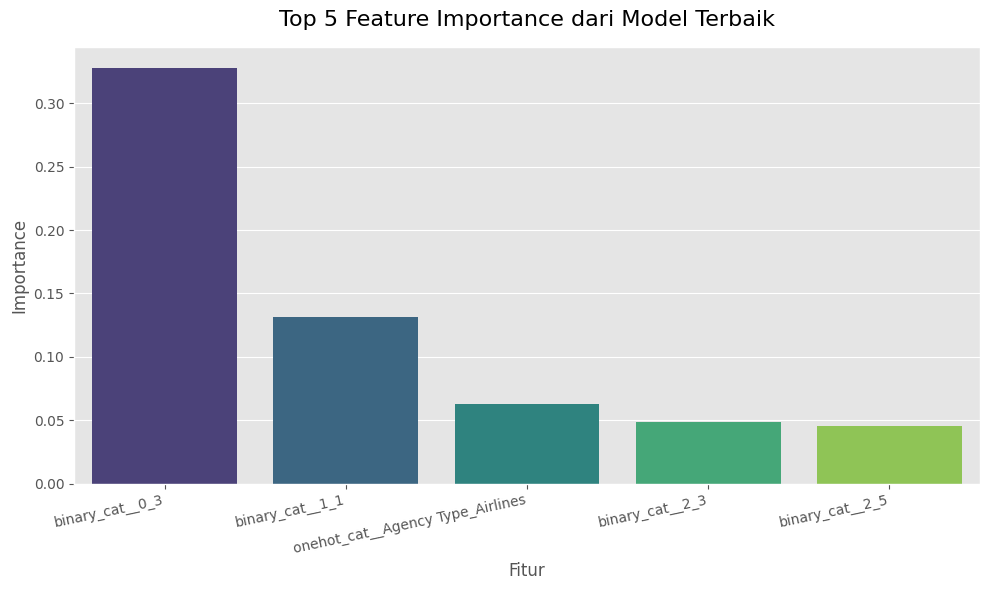

In [166]:
# Ambil 10 fitur teratas untuk visualisasi yang lebih jelas
top_features = df_feat_imp.head(5)

# Buat bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='features', y='importance', data=top_features, palette='viridis')
plt.title('Top 5 Feature Importance dari Model Terbaik', fontsize=16, pad=15)
plt.xlabel('Fitur', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=12, ha='right', fontsize=10)
plt.tight_layout()

# Simpan grafik
plt.savefig('feature_importance_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Komparasi Model dan Confusion Matrix


=== Model Before Tuning ===
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      3219
           1       0.10      0.28      0.15       107

    accuracy                           0.89      3326
   macro avg       0.54      0.60      0.54      3326
weighted avg       0.95      0.89      0.92      3326

F1 Score untuk kelas 0: 0.9438
F1 Score untuk kelas 1: 0.1460
F1 Score (macro avg): 0.5449


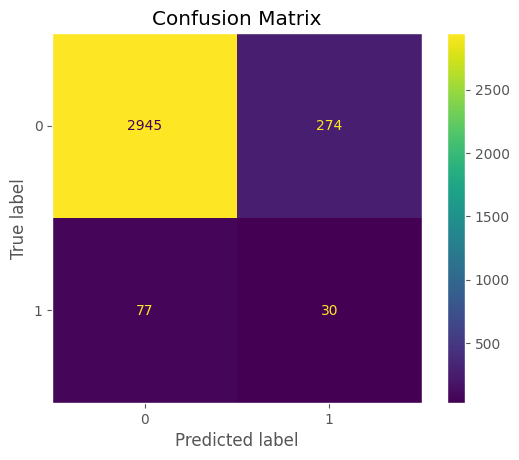

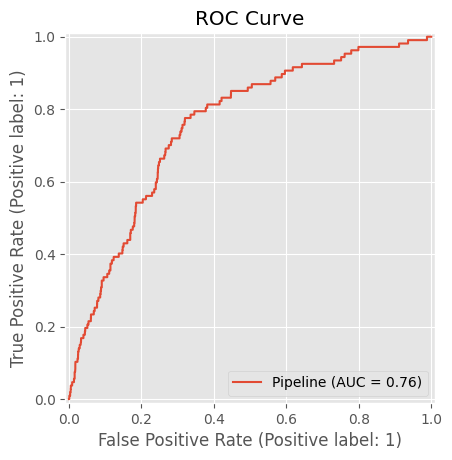

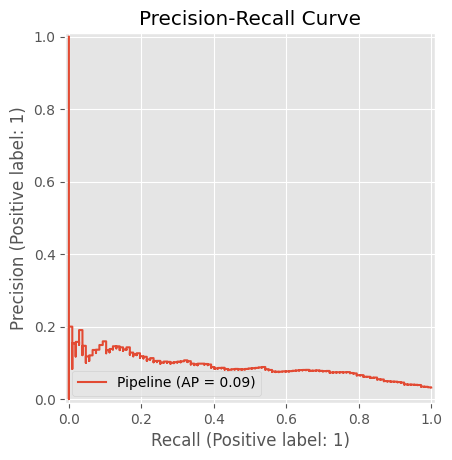

=== Additional Metrics (for imbalanced data) ===
Accuracy: 0.8945
F1 Score (macro): 0.5449
Precision: 0.0987
Recall: 0.2804
Balanced Accuracy: 0.5976
G-Mean: 0.5065
ROC AUC: 0.7571
PR AUC: 0.0908

=== Model After Tuning ===
Fitting 5 folds for each of 512 candidates, totalling 2560 fits
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      3219
           1       0.09      0.38      0.15       107

    accuracy                           0.86      3326
   macro avg       0.53      0.63      0.54      3326
weighted avg       0.95      0.86      0.90      3326

F1 Score untuk kelas 0: 0.9231
F1 Score untuk kelas 1: 0.1488
F1 Score (macro avg): 0.5360


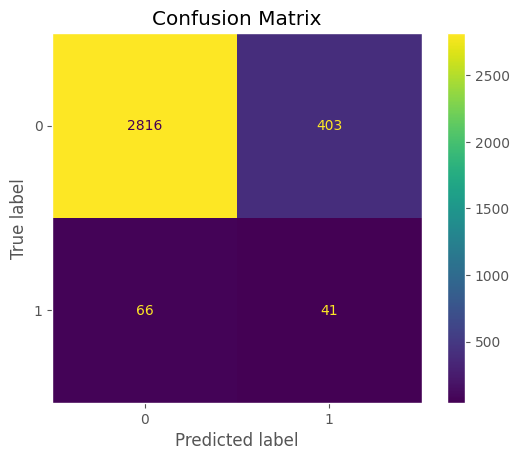

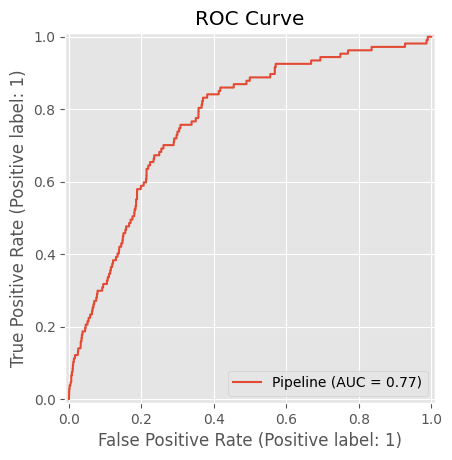

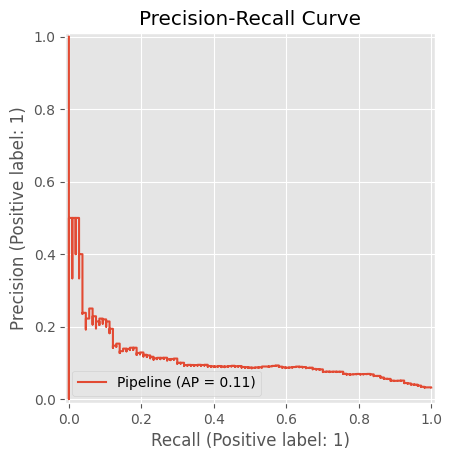

=== Additional Metrics (for imbalanced data) ===
Accuracy: 0.8590
F1 Score (macro): 0.5360
Precision: 0.0923
Recall: 0.3832
Balanced Accuracy: 0.6290
G-Mean: 0.5790
ROC AUC: 0.7699
PR AUC: 0.1127

=== Comparison of Metrics ===


,Metric,Best Model (Before Tuning),Best Model (After Tuning)
0,Accuracy,0.894468,0.858990
1,F1 Score (macro),0.544872,0.535974
2,Precision,0.098684,0.092342
3,Recall,0.280374,0.383178
4,Balanced Accuracy,0.597627,0.628992
5,G-Mean,0.506467,0.578970
6,ROC AUC,0.757082,0.769873
7,PR AUC,0.090797,0.112699


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, average_precision_score, balanced_accuracy_score, confusion_matrix
from imblearn.metrics import geometric_mean_score

# Konsolidasi fungsi evaluate_model (dari kode Anda)
def evaluate_model(model, X_test, y_test, plot=False):
    y_pred = model.predict(X_test)

    # Hitung metrik
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score (macro)': f1_score(y_test, y_pred, average='macro'),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'G-Mean': geometric_mean_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
        'PR AUC': average_precision_score(y_test, model.predict_proba(X_test)[:, 1])
    }

    if plot:
        # Classification report
        print("=== Classification Report ===")
        print(classification_report(y_test, y_pred))

        # F1 Score per kelas
        f1_per_class = f1_score(y_test, y_pred, average=None)
        print(f"F1 Score untuk kelas 0: {f1_per_class[0]:.4f}")
        print(f"F1 Score untuk kelas 1: {f1_per_class[1]:.4f}")
        print(f"F1 Score (macro avg): {f1_score(y_test, y_pred, average='macro'):.4f}")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.title("Confusion Matrix")
        plt.grid(False)
        plt.show()

        # ROC curve
        RocCurveDisplay.from_estimator(model, X_test, y_test)
        plt.title("ROC Curve")
        plt.show()

        # Precision-Recall curve
        PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
        plt.title("Precision-Recall Curve")
        plt.show()

        # Cetak metrik tambahan
        print("=== Additional Metrics (for imbalanced data) ===")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name}: {metric_value:.4f}")

    return metrics

# Evaluasi model sebelum dan sesudah tuning
print("\n=== Model Before Tuning ===")
try:
    best_model.fit(X_train, y_train)
except Exception as e:
    print(f"Error during fitting best_model: {e}")
    raise
metrics_before = evaluate_model(best_model, X_test, y_test, plot=True)

print("\n=== Model After Tuning ===")
try:
    model.fit(X_train, y_train)
except Exception as e:
    print(f"Error during GridSearchCV fitting: {e}")
    raise
best_model_after_tuning = model.best_estimator_
metrics_after = evaluate_model(best_model_after_tuning, X_test, y_test, plot=True)

# Bandingkan hasil
comparison_df = pd.DataFrame({
    'Metric': metrics_before.keys(),
    'Best Model (Before Tuning)': metrics_before.values(),
    'Best Model (After Tuning)': metrics_after.values()
})
print("\n=== Comparison of Metrics ===")
comparison_df

In [169]:
from sklearn.metrics import recall_score, f1_score
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_recall = f1_score(y_train, y_train_pred, average='macro')
test_recall = f1_score(y_test, y_test_pred, average='macro')

print(f"F1 pada data train: {train_recall:.4f}")
print(f"F1 pada data test: {test_recall:.4f}")

F1 pada data train: 0.5760
F1 pada data test: 0.5360


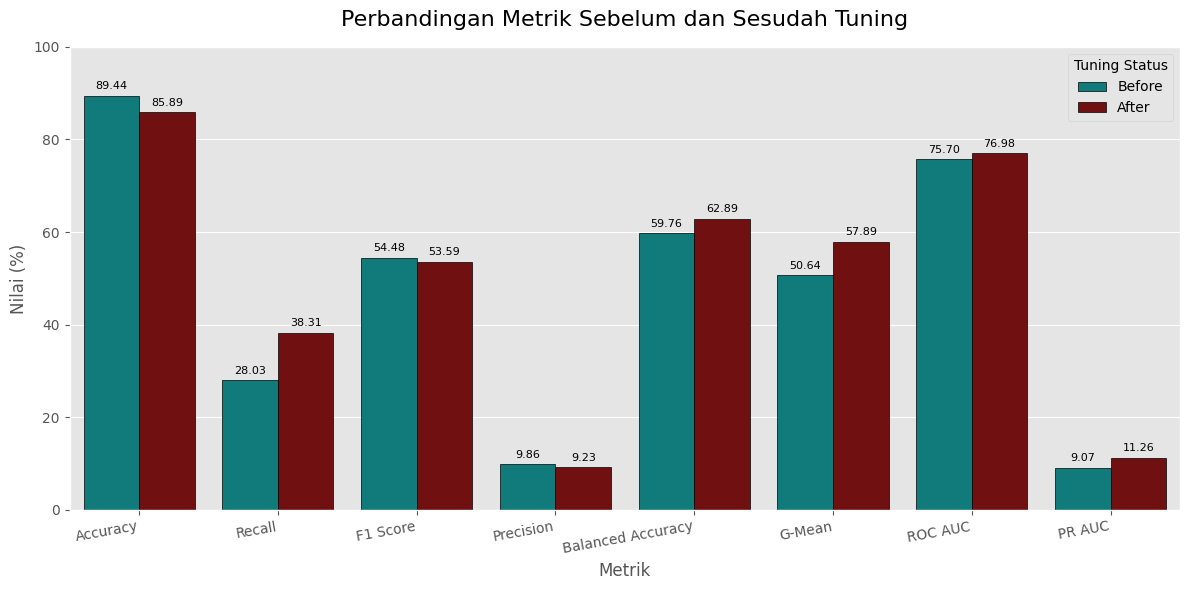

In [171]:
# Data metrik sebelum dan sesudah tuning
metrics = ['Accuracy', 'Recall', 'F1 Score', 'Precision', 'Balanced Accuracy', 'G-Mean', 'ROC AUC', 'PR AUC']
before_tuning = [89.44, 28.03, 54.48, 9.86, 59.76, 50.64, 75.70, 9.07]  # Placeholder untuk sebelum tuning
after_tuning = [85.89, 38.31, 53.59, 9.23, 62.89, 57.89, 76.98, 11.26]

# Buat DataFrame
data = pd.DataFrame({
    'Metric': metrics * 2,
    'Value': before_tuning + after_tuning,
    'Tuning': ['Before'] * len(metrics) + ['After'] * len(metrics)
})

# Set style untuk visualisasi
plt.style.use('ggplot')

# Buat figure
plt.figure(figsize=(12, 6))

# Buat bar chart
sns.barplot(x='Metric', y='Value', hue='Tuning', data=data, palette=['darkcyan', 'maroon'], edgecolor='black')

# Kustomisasi plot
plt.title('Perbandingan Metrik Sebelum dan Sesudah Tuning', fontsize=16, pad=15)
plt.xlabel('Metrik', fontsize=12)
plt.ylabel('Nilai (%)', fontsize=12)
plt.xticks(rotation=10, ha='right', fontsize=10)
plt.legend(title='Tuning Status')
plt.ylim(0, 100)  # Rentang 0-100% untuk semua metrik
for i, v in enumerate(before_tuning + after_tuning):
    plt.text(i % len(metrics) + (i // len(metrics) - 0.5) * 0.4, v + 1, f'{v:.2f}', ha='center', va='bottom', fontsize=8)

# Simpan grafik sebagai file
plt.tight_layout()
plt.savefig('comparison_metrics_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [172]:
# Simpan model terbaik ke dalam file
with open('xgbclassifier_best_model.pkl', 'wb') as file:
    pickle.dump(best_model_after_tuning, file)

# Kesimpulan Bisnis dan Rekomendasi Bisnis

**Kesimpulan Bisnis**

Berdasarkan analisis data dan pengembangan model klasifikasi untuk deteksi klaim asuransi perjalanan, berikut adalah kesimpulan bisnis utama yang dapat mendukung agensi dalam mengelola klaim secara lebih akurat dan efisien:
1. Peningkatan Efisiensi Pengelolaan Klaim:
    - Model setelah tuning (Recall: 38,31%, ROC AUC: 76,98%, PR AUC: 11,26%) menunjukkan peningkatan kemampuan mengidentifikasi klaim valid dibandingkan sebelum tuning (Recall: 28,03%). Meskipun akurasi sedikit menurun (dari 89,44% ke 85,89%), peningkatan recall dan balanced accuracy (62,89%) membuat model lebih sensitif terhadap klaim positif, yang krusial untuk meminimalkan penolakan klaim yang sah.
    - Implikasi Bisnis: Agensi dapat mengurangi waktu dan sumber daya untuk verifikasi manual, meningkatkan efisiensi operasional, dan mempercepat proses klaim, sehingga meningkatkan kepuasan pelanggan.
2. Identifikasi Fitur Kunci yang Mempengaruhi Klaim:
    - Fitur seperti Duration, Net Sales, Commission, Destination, dan Product Name kemungkinan besar memiliki pengaruh signifikan terhadap status klaim (berdasarkan pipeline preprocessing dan model ensemble seperti Random Forest atau XGBoost). Misalnya, perjalanan jangka panjang atau destinasi tertentu (seperti Amerika atau Eropa) cenderung menghasilkan lebih banyak klaim.
    - Implikasi Bisnis: Agensi dapat menyesuaikan strategi penetapan premi atau kebijakan underwriting, seperti menetapkan premi lebih tinggi untuk destinasi berisiko tinggi atau durasi perjalanan panjang, untuk mengelola risiko dengan lebih baik.
3. Penanganan Ketidakseimbangan Data:
    - Dataset menunjukkan ketidakseimbangan kelas yang signifikan (98,47% klaim "No" vs. 1,53% klaim "Yes"). Model setelah tuning lebih baik dalam mendeteksi kelas minoritas ("Yes"), seperti ditunjukkan oleh peningkatan recall dan G-Mean (57,89%). Namun, precision rendah (9,23%) mengindikasikan adanya false positives.
    - Implikasi Bisnis: Dengan mengurangi false positives melalui tuning lebih lanjut atau teknik seperti SMOTE, agensi dapat menghindari pembayaran klaim tidak valid, menghemat biaya signifikan, sambil tetap memastikan klaim valid diproses dengan benar.
4. Segmentasi Pelanggan untuk Strategi yang Lebih Tepat:
    - Fitur demografis seperti Age dan Gender (meskipun banyak nilai hilang pada Gender) dapat memberikan wawasan tentang pola klaim. Misalnya, kelompok usia tertentu mungkin lebih sering mengajukan klaim karena faktor kesehatan atau perilaku perjalanan.
    - Product Name dan Distribution Channel juga relevan. Produk seperti "2 way Comprehensive Plan" atau kanal distribusi online mungkin memiliki tingkat klaim yang berbeda.
    - Implikasi Bisnis: Agensi dapat mengembangkan produk asuransi yang disesuaikan untuk segmen pelanggan tertentu (misalnya, paket untuk pelancong muda atau lansia) dan mengoptimalkan strategi pemasaran melalui kanal distribusi yang lebih menguntungkan.
5. Mitigasi Risiko Keuangan:
    - Model yang lebih akurat dalam mendeteksi klaim valid membantu mengurangi kerugian akibat pembayaran klaim yang tidak memenuhi syarat. Peningkatan recall memastikan klaim sah tidak ditolak, menjaga reputasi dan kepercayaan pelanggan.
    - Implikasi Bisnis: Penghematan dari penolakan klaim tidak valid dapat dialokasikan untuk meningkatkan layanan pelanggan atau mengembangkan produk baru. Kepercayaan pelanggan yang terjaga juga dapat meningkatkan loyalitas dan retensi.
6. Keunggulan Kompetitif di Pasar:
    - Dengan memanfaatkan model prediktif ini, agensi dapat menawarkan proses klaim yang lebih cepat, transparan, dan adil, terutama di pasar yang mewajibkan asuransi perjalanan (misalnya, Eropa dan Amerika).
    - Analisis prediktif juga dapat diperluas untuk mendeteksi potensi penipuan (fraud detection), mengurangi risiko kerugian lebih lanjut.
    - Implikasi Bisnis: Proses klaim yang efisien dan akurat dapat menjadi keunggulan kompetitif, menarik lebih banyak pelanggan dan memperkuat posisi agensi di pasar asuransi perjalanan.

**Rekomendasi Bisnis**

**Jangka Pendek**
1. Integrasikan Model ke Sistem Operasional
    - Tindakan: Terapkan model XGBoost (dtclassifier_best_model.pkl) ke sistem operasional untuk prediksi real-time status klaim. Model ini telah meningkatkan recall menjadi 38,31%, sehingga dapat mendeteksi lebih banyak klaim valid dan mengurangi penolakan yang salah.
    - Manfaat: Meningkatkan efisiensi dengan mengotomatisasi validasi awal klaim, menghemat waktu staf, dan memungkinkan fokus pada kasus yang lebih kompleks.
    - Langkah: Uji model dalam lingkungan sandbox sebelum peluncuran penuh untuk memastikan akurasi dan kompatibilitas dengan sistem yang ada.

2. Tingkatkan Precision dengan Penyesuaian Threshold
    - Tindakan: Sesuaikan threshold prediksi model (default 0,5) ke nilai yang lebih tinggi (misalnya, 0,7) untuk meningkatkan precision (saat ini 9,23%), yang akan mengurangi false positives (klaim tidak valid yang salah diprediksi sebagai valid).
    - Manfaat: Mengurangi biaya verifikasi ulang akibat false positives, meskipun mungkin sedikit mengorbankan recall.
    - Langkah: Lakukan analisis sensitivitas pada threshold untuk menemukan keseimbangan optimal antara precision dan recall, sesuai dengan prioritas bisnis.

3. Atasi Data Hilang untuk Fitur Kunci
    - Tindakan: Tingkatkan pengumpulan data untuk fitur seperti Gender (yang memiliki ~71% data hilang) melalui formulir yang lebih lengkap atau insentif bagi pelanggan untuk memberikan informasi.
    - Manfaat: Data yang lebih lengkap akan meningkatkan akurasi model dan memberikan wawasan lebih mendalam tentang pengaruh demografi terhadap klaim.
    - Langkah: Mulai dengan kampanye pengumpulan data sederhana, seperti diskon kecil untuk pelanggan yang melengkapi profil mereka.

4. Fokus pada Destinasi dan Produk Berisiko Tinggi
    - Tindakan: Berikan perhatian khusus pada destinasi seperti UNITED STATES dan SINGAPORE, serta produk seperti 2 way Comprehensive Plan dan Annual Silver Plan, yang menunjukkan tingkat klaim lebih tinggi berdasarkan grafik distribusi.
    - Manfaat: Meningkatkan layanan pelanggan di segmen ini dapat mengurangi keluhan dan meningkatkan kepuasan, sekaligus memungkinkan penyesuaian premi untuk mengelola risiko.
    - Langkah: Latih tim layanan pelanggan untuk menangani klaim dari destinasi dan produk ini dengan lebih responsif, dan pertimbangkan edukasi pelanggan tentang risiko di destinasi tertentu.

**Jangka Panjang**
1. Analisis Feature Importance untuk Penetapan Premi dan Harga
    - Tindakan: Gunakan feature importance dari XGBoost (misalnya, Duration, Age, Destination, Product Name, Net Sales, Commission) untuk menyempurnakan kebijakan premi. Contohnya, tetapkan premi lebih tinggi untuk perjalanan berdurasi panjang (~400 hari) atau pelancong berusia di atas 50 tahun, yang memiliki risiko klaim lebih tinggi.
    - Manfaat: Penetapan premi berbasis risiko akan meningkatkan profitabilitas dengan menyeimbangkan pembayaran klaim dan pendapatan polis.
    - Langkah: Lakukan analisis rutin menggunakan XGBoost untuk memperbarui skor feature importance berdasarkan data terbaru, dan gunakan hasilnya untuk simulasi pricing.

2. Pantau dan Latih Ulang Model Secara Berkala
    - Tindakan: Pantau performa model secara berkala (misalnya, setiap 3–6 bulan) dan latih ulang dengan data baru untuk menjaga akurasi prediksi, terutama karena pola klaim dapat berubah seiring waktu.
    - Manfaat: Memastikan model tetap relevan dan akurat dalam mendeteksi klaim, mendukung efisiensi jangka panjang dan kepuasan pelanggan.
    - Langkah: Siapkan pipeline otomatis untuk pengumpulan data baru, evaluasi performa (menggunakan metrik seperti recall dan ROC AUC), dan retraining model.

3. Kembangkan Produk Khusus untuk Segmen Berisiko Tinggi
    - Tindakan: Buat paket asuransi khusus untuk segmen berisiko tinggi, seperti pelancong di atas 50 tahun, perjalanan berdurasi panjang, atau destinasi seperti SINGAPORE. Contohnya, tawarkan polis dengan cakupan tambahan untuk biaya medis di AS.
    - Manfaat: Memenuhi kebutuhan pelanggan di segmen ini akan meningkatkan penjualan polis dan loyalitas, sekaligus mengelola risiko dengan premi yang sesuai.
    - Langkah: Lakukan riset pasar untuk memahami kebutuhan segmen ini, lalu rancang produk dengan bantuan tim aktuaria berdasarkan wawasan data.

4. Jelajahi Deteksi Penipuan untuk Penghematan Lebih Lanjut
    - Tindakan: Kembangkan model deteksi penipuan menggunakan wawasan dari feature importance (misalnya, pola anomali pada Net Sales atau Commission) untuk mengidentifikasi klaim yang mencurigakan.
    - Manfaat: Mengurangi kerugian finansial akibat klaim penipuan, yang merupakan masalah umum dalam industri asuransi.
    - Langkah: Mulai dengan analisis anomali pada data klaim historis, lalu integrasikan fitur deteksi penipuan ke dalam model XGBoost atau bangun model terpisah untuk tujuan ini.

5. Optimalkan Strategi Pemasaran Berbasis Data
    - Tindakan: Manfaatkan dominasi saluran Online (>90%) untuk meningkatkan investasi dalam pemasaran digital, seperti iklan bertarget untuk pelancong ke destinasi populer (SINGAPORE, MALAYSIA) atau pengguna produk komprehensif.
    - Manfaat: Meningkatkan jangkauan dan konversi penjualan polis dengan biaya pemasaran yang lebih efisien.
    - Langkah: Gunakan data pelanggan untuk segmentasi pasar (misalnya, pelancong muda vs. lansia) dan rancang kampanye yang dipersonalisasi berdasarkan preferensi destinasi atau produk.